# **IBL brain-wide map dataset**

## **Overview**

### **The brain-wide map dataset**

The International Brain Laboratory (IBL) Brainwide Map project set out to map neural activity across the entire mouse brain at single-spike, cellular resolution during a standardized decision-making task. The resulting dataset has been made publicly available.

The dataset includes:


* Data collected across **12 laboratories**

* Recordings from **139 mice**

* A total of **459 behavioral sessions**

* **699 Neuropixels probe insertions**

* Coverage of **281 brain regions**

* **621,733 recorded neurons**, including

* **75,708 good neurons**


![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/bwm_recordings.png)



### **Recording Plan**

Neural activity was recorded using Neuropixels probes, targeted according to a standardized grid system with insertion sites spaced 500 µm apart.

The recording system aimed to:
* Achieve uniform coverage across the brain

* Prioritize regions with known anatomical connectivity (e.g., the cerebellum and medulla were sampled from the right hemisphere)

* Replicate each recording site in at least two independent laboratories

* Evaluate the reproducibility of neural activity across subjects and experimental sites (via the "repeated site")

* Investigate bilateral and interhemispheric interactions (via the "bilateral sites")

![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/bwm_plan.png)


### **Decision making task**

In the IBL decision making task a visual stimulus appears at the edge of the screen and mice must bring the stimulus to the screen centre by moving a wheel with their front two paws. If they successfully bring the stimulus to the screen centre, they receive a reward of sugar water ; if however they move the wheel in the wrong direction until the stimulus reaches beyond the screen edge, a white noise tone is played. To initiate a trial, the mouse must hold the wheel still for a continuous period between 0.4-0.7s ; they are then alerted of the start of the trial by the simultaneous presentation of the stimulus on the screen and a go cue tone. Mice have a maximum of 60s to make a decision before the trial times out and a white noise tone is played.

Varying contrasts of visual stimulus are shown throughout the session (100%, 25%, 12.5%, 6.25% and 0%). The probability of the stimulus appearing on the left or the right changes between blocks of trials. During 0% contrast trials (where no stimulus appears on the screen but a wheel response is required), the mice can use the inferred block structure to guide their decision.


![](https://ibl-brain-wide-map-public.s3.us-east-1.amazonaws.com/sample_data/Neuromatch/figures/task.png)


### **Accessing the data**
For the purposes of this course, we have precomputed task-aligned peri-stimulus time histograms (PSTHs) for all good clusters in the dataset. This allows you to quickly begin working with the data using a simplified and accessible format. The tutorial below is based on this preprocessed data.

To access the full dataset, including raw electrophysiology (action potential and LFP bands), spike sorting output, wheel movement, video recordings, and pose estimation data please refer to this [this introductary notebook](https://colab.research.google.com/drive/1_1qfa-DLDbezyFXguFOnJJWF5aJ5AH0i#scrollTo=-TJR7XEgtBxS) and [this tutorial](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7#scrollTo=hRZA78AoaBIC).



> *All data are made available under the CC BY 4.0 license.*

## **Installation and setup**

The code blocks in this section install and import required packages. We also define a set of utility functions that will be used to download and load data throughout the rest of the tutorial. **Make sure these cells are run before continuing onto the next sections.**

### **Install dependencies**

In [71]:
! pip install ONE-api --quiet
! pip install ibllib --quiet

### **Setup ONE**

### **Define imports**

In [ ]:
# When running in jupyter set number of threads to 1
import os
os.environ.setdefault('ONE_HTTP_DL_THREADS', '1')

# Standard library imports
import sys
import zipfile
import pathlib
from pathlib import Path


# Third-party library imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import sparse
import numpy as np
from scipy.ndimage import gaussian_filter1d
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mne
from mne_connectivity import spectral_connectivity_epochs
from collections import defaultdict
from itertools import combinations
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import fdrcorrection

import warnings
warnings.filterwarnings("ignore")

# IBL-specific library imports
from one.api import ONE
from one.remote.aws import s3_download_file
from iblutil.util import Bunch

### **Define loading utility functions**

In [73]:
def download_data(event):
    # Ensure event is valid
    assert event in ['firstMove', 'stimOn', 'feedback'], 'event must be one of "firstMove", "stimOn" or "feedback"'

    # Set custom local path
    local_base_path = pathlib.Path(r"IBL BWM")
    data_folder_path = local_base_path.joinpath(f'data_{event}')

    # Return if data already exists
    if data_folder_path.exists():
        print(f"✅ Data for '{event}' already exists locally at: {data_folder_path}")
        return

    # Start download if not found
    print(f"Data for '{event}' not found. Starting download to {local_base_path}...")

    # Set remote and local file names
    fname = f'data_{event}.zip'
    s3_data_path = f'sample_data/Neuromatch/{fname}'
    local_zip_path = local_base_path.joinpath(fname)

    # Create target directory if needed
    local_base_path.mkdir(exist_ok=True, parents=True)

    # Download zip file from S3
    try:
        s3_download_file(s3_data_path, local_zip_path)
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return
        
    # Unzip file
    print(f"Unzipping {local_zip_path}...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(local_base_path)

    # Remove zip file after extraction
    local_zip_path.unlink()
    print(f"✅ Download and extraction for '{event}' complete.")


def get_data_path(event):
    """
    Return local data path for event.
    """
    base_path = pathlib.Path(r"C:/Users/Zesyrus/IBL BWM")
    data_path = base_path.joinpath(f'data_{event}')
    return data_path


def load_metadata(event):
    """
    Load metadata files from local path.
    """
    metadata = Bunch()
    data_path = get_data_path(event)
    
    metadata['clusters'] = pd.read_parquet(data_path.joinpath('clusters.pqt'))
    metadata['trials'] = pd.read_parquet(data_path.joinpath('trials.pqt'))
    metadata['sessions'] = pd.read_parquet(data_path.joinpath('sessions.pqt'))
    metadata['times'] = np.load(data_path.joinpath('t.npy'))
    
    metadata['nbins'] = metadata['times'].size
    metadata['dt'] = np.round(np.median(np.diff(metadata['times'])), 2)
    metadata['data_path'] = data_path

    return metadata


def load_times(data_path):
    """
    Load time bins vector.
    """
    return np.load(data_path.joinpath('t.npy'))


def load_psth(data_path, pid, nbins=150):
    """
    Load PSTH for probe insertion ID.
    """
    psth_sparse_matrix = sparse.load_npz(data_path.joinpath(f'{pid}.npz'))
    psth = psth_sparse_matrix.toarray()
    psth = psth.reshape(psth.shape[0], -1, nbins)
    return psth

### **Define processing utility functions** <a name="Utility-functions"></a>

In [74]:
def split_trials_by_variable(trials, split='contrast'):
  trials = trials.set_index('psth_index')
  if split == 'contrast':
    trials['contrast'] = np.nansum([trials['contrastLeft'], trials['contrastRight']], axis=0) * 100
    grp = trials.groupby('contrast')
  elif split == 'signed contrast':
    trials['signedContrast'] = np.nansum([-1 * trials['contrastLeft'], trials['contrastRight']], axis=0) * 100
    grp = trials.groupby('signedContrast')
  elif split == 'stimulus':
    trials['stimulus'] = 'right'
    trials.loc[trials['contrastRight'].isna(), 'stimulus'] = 'left'
    grp = trials.groupby('stimulus')
  elif split == 'choice':
    grp = trials.groupby('choice')
  elif split == 'block':
    grp = trials.groupby('probabilityLeft')
  else:
    raise NotImplementedError('split must be one of "contrast", "signed contrast", "stimulus", "choice" or "block"')

  return grp.groups


def get_avg_psth_for_insertion(pid, meta, reg=None, uuids=None, split=None):

  df = meta.clusters[meta.clusters['pid'] == pid]
  df = df[['acronym', 'pid', 'uuids', 'cluster_id', 'psth_index']]
  sp = load_psth(meta.data_path, pid, nbins=meta.nbins)

  if reg is not None:
    in_reg = df['acronym'] == reg
    sp = sp[:, in_reg.values, :]
    df = df[in_reg].reset_index(drop=True)

  if uuids is not None:
    in_uuid = df['uuids'].isin(uuids)
    sp = sp[:, in_uuid.values, :]
    df = df[in_uuid].reset_index(drop=True)

  if split is None:
    psth = sp.mean(axis=0) / meta['dt']
  else:
    psth = dict()
    eid = meta.sessions[meta.sessions['pid'] == pid].iloc[0]['eid']
    trials = meta.trials[meta.trials['eid'] == eid].reset_index(drop=True)
    grps = split_trials_by_variable(trials, split=split)

    for key, vals in grps.items():
      psth[key] = sp[vals, :, :].mean(axis=0)

  return psth, df

def get_avg_psth_for_region(reg, meta, split=None):
  clusters = meta.clusters[meta.clusters['acronym'] == reg]
  pids = clusters['pid'].unique()
  all_df = []
  all_psth = []
  for pid in pids:
    psth, df = get_avg_psth_for_insertion(pid, meta, reg=reg, split=split)
    all_df.append(df)
    all_psth.append(psth)

  all_df = pd.concat(all_df).reset_index(drop=True)
  if split is None:
    all_psth = np.concatenate(all_psth)
  else:
    all_psth = {key: np.concatenate([d[key] for d in all_psth if key in d.keys()])
    for key in all_psth[0]}


  return all_psth, all_df


def get_avg_psth_for_clusters(uuids, meta, split=None):
  clusters = meta.clusters[meta.clusters['uuids'].isin(uuids)]
  pids = clusters['pid'].unique()
  all_df = []
  all_psth = []
  for pid in pids:
    psth, df = get_avg_psth_for_insertion(pid, meta, uuids=uuids, split=split)
    all_df.append(df)
    all_psth.append(psth)

  all_df = pd.concat(all_df).reset_index(drop=True)
  if split is None:
    all_psth = np.concatenate(all_psth)
  else:
    all_psth = {key: np.concatenate([d[key] for d in all_psth if key in d.keys()])
    for key in all_psth[0]}

  return all_psth, all_df



def get_psth_for_insertion(pid, meta, reg=None, uuids=None):

  df = meta.clusters[meta.clusters['pid'] == pid]
  df = df[['acronym', 'pid', 'uuids', 'cluster_id', 'psth_index']]
  sp = load_psth(meta.data_path, pid, nbins=meta.nbins)

  if reg is not None:
    in_reg = df['acronym'] == reg
    sp = sp[:, in_reg.values, :]
    df = df[in_reg].reset_index(drop=True)

  if uuids is not None:
    in_uuid = df['uuids'].isin(uuids)
    sp = sp[:, in_uuid.values, :]
    df = df[in_uuid].reset_index(drop=True)


  eid = meta.sessions[meta.sessions['pid'] == pid].iloc[0]['eid']
  trials = meta.trials[meta.trials['eid'] == eid].reset_index(drop=True)
  psth = sp / meta['dt']

  return psth, df, trials


def get_psth_for_region(reg, meta):

  clusters = meta.clusters[meta.clusters['acronym'] == reg]
  pids = clusters['pid'].unique()
  all_clust = []
  all_psth = []
  all_trials = []
  for pid in pids:
    psth, clust, trials = get_psth_for_insertion(pid, meta, reg=reg)
    all_clust.append(clust)
    all_psth.append(psth)
    all_trials.append(trials)

  return all_psth, all_clust, all_trials


def get_psth_for_clusters(uuids, meta):

  clusters = meta.clusters[meta.clusters['uuids'].isin(uuids)]
  pids = clusters['pid'].unique()
  all_clust = []
  all_psth = []
  all_trials = []
  for pid in pids:
    psth, clust, trials = get_psth_for_insertion(pid, meta, uuids=uuids)
    all_clust.append(clust)
    all_psth.append(psth)
    all_trials.append(trials)

  return all_psth, all_clust, all_trials

def get_region_signal(psth_data, method='pca'):
    """
    Reduces multi-neuron PSTH data to a single time series per trial for a region.

    Args:
        psth_data (np.ndarray):
            PSTH data for one region and one session, with shape
            (trials, neurons, time_bins).
        method (str, optional):
            Method to use. 'pca' (default) for the first principal component
            or 'average' for a simple mean.

    Returns:
        np.ndarray:
            A single representative signal for the region with shape
            (trials, time_bins).
    """
    if psth_data.shape[1] <= 1:  # Only one or zero neurons
        return psth_data.squeeze(axis=1)

    if method == 'average':
        return np.mean(psth_data, axis=1)

    elif method == 'pca':
        # Reshape data for PCA: (n_samples, n_features) -> ((trials * time_bins), neurons)
        n_trials, n_neurons, n_time_bins = psth_data.shape
        # Ensure there are samples to fit
        if n_trials == 0:
            return np.array([]).reshape(0, n_time_bins)
            
        reshaped_data = psth_data.transpose(0, 2, 1).reshape(-1, n_neurons)

        # Fit PCA to find the dominant pattern across all trials and time
        pca = PCA(n_components=1)
        pca.fit(reshaped_data)

        # Project the original data onto this first principal component
        pc1_vector = pca.components_[0]
        # Use einsum for a clean and efficient dot product along the neuron axis
        region_signal = np.einsum('tnf,n->tf', psth_data, pc1_vector)
        return region_signal

    else:
        raise ValueError("Method must be 'pca' or 'average'")

## **2. Data Access**
In this section we will show how to **download and load the preprocessed data** and walk through the **structure and content of the data** to help you become familiar with its organisation and key components.

### **Data Format**
To facilitate analysis, we have prepared three ZIP files containing data aligned to different key task events:

* `data_stimOn.zip` — aligned to **stimulus onset**, the moment the visual stimulus appears on the screen

* `data_firstMove.zip` — aligned to the **first movement**, when the mouse initiates a wheel turn that moves the stimulus past threshold

* `data_feedback.zip` — aligned to **feedback time**, when the mouse receives feedback based on its choice


Each ZIP archive contains the following files:

* `clusters.pqt` — metadata for each recorded cluster (e.g. brain region)

* `trials.pqt` — behavioral trial data (e.g. stimulus, choice, contrast)

* `sessions.pqt` — metadata for each recording session (e.g. subject, lab)

* `t.npy` — timepoints for the peri-stimulus time histogram (PSTH); spans from -0.5 s to +1.0 s around the event in 10 ms steps

* `{pid}.npz` — PSTH data for each individual probe insertion, labeled by its unique probe ID (pid)


🔍 What are eid and pid?

Throughout the dataset and code, you will encounter two key identifiers:

* `eid` — the experiment/session ID, uniquely identifying each behavioral session

* `pid` — the probe insertion ID, uniquely identifying each Neuropixels insertion

A single eid may be associated with multiple pids, since several probes can be recorded from during the same session.

### **Downloading the data**

The data for a given aligned event can be downloaded in the following way.

In [75]:
download_data('firstMove')
download_data('stimOn')
download_data('feedback')

✅ Data for 'firstMove' already exists locally at: IBL BWM\data_firstMove
✅ Data for 'stimOn' already exists locally at: IBL BWM\data_stimOn
✅ Data for 'feedback' already exists locally at: IBL BWM\data_feedback


### **Loading metadata**
We can load all of the metadata (cluster, trial, session and timestamps data) in the following way.

In [76]:
meta = load_metadata('stimOn')
print(f'Meta data contains the following keys: {list(meta.keys())}')

Meta data contains the following keys: ['clusters', 'trials', 'sessions', 'times', 'nbins', 'dt', 'data_path']


### **Mapping sessions to regions of interest**

In order to perform region-wise analyses, we need to map each session to its recorded regions of interest.

In [ ]:
# Load feedback-aligned metadata
print("Loading metadata aligned to feedback time...")
meta_feedback = load_metadata('feedback')

# Merge clusters with session info for eid lookup
merged_clusters = pd.merge(meta_feedback.clusters, meta_feedback.sessions[['pid', 'eid']], on='pid')
print("✅ Metadata loaded and processed.")

# Define reward-related ROIs (Allen CCF acronyms)
rois = [
    "PL", "PVT", "LH", "SNc", "CA1", "CA3", "DG", "AM", "VTA", "CP", "SNr", "ACAd", "ACAv"
]

# Filter ROIs present in dataset
available_rois_in_dataset = merged_clusters['acronym'].unique()
rois_in_dataset = [roi for roi in rois if roi in available_rois_in_dataset]

print("\nRegions of Interest")
print(f"ROIs specified for analysis: {rois}")
print(f"ROIs found in the dataset: {rois_in_dataset}")


Loading metadata aligned to feedback time...
✅ Metadata loaded and processed.

--- Regions of Interest ---
ROIs specified for analysis: ['PL', 'PVT', 'LH', 'SNc', 'CA1', 'CA3', 'DG', 'AM', 'VTA', 'CP', 'SNr', 'ACAd', 'ACAv']
ROIs found in the dataset: ['PL', 'PVT', 'LH', 'SNc', 'CA1', 'CA3', 'DG', 'AM', 'VTA', 'CP', 'SNr', 'ACAd', 'ACAv']


### **Mapping ROI pairs to sessions**

In [ ]:
# Map each session to its recorded regions
session_to_regions_map = merged_clusters.groupby('eid')['acronym'].unique().apply(set).to_dict()

# Map ROI pairs to sessions where both are present
pair_to_sessions_map = defaultdict(list)

# List all unique ROI pairs
roi_pairs = list(combinations(rois_in_dataset, 2))

# Fill map: for each pair, find sessions with both regions
for pair in roi_pairs:
    region_a, region_b = pair
    for eid, recorded_regions in session_to_regions_map.items():
        if region_a in recorded_regions and region_b in recorded_regions:
            pair_to_sessions_map[pair].append(eid)

# Print summary of found pairs and session counts
print("Found co-recorded sessions for the following ROI pairs:")
count = 0
for pair, sessions in pair_to_sessions_map.items():
    if sessions:
        count += 1
        print(f"- {pair}: Found in {len(sessions)} session(s)")

if count == 0:
    print("No sessions with co-recorded ROI pairs were found. Please check your ROI list or dataset.")
else:
    print(f"\n✅ Found a total of {count} co-recorded pairs.")


Found co-recorded sessions for the following ROI pairs:
- ('PL', 'PVT'): Found in 1 session(s)
- ('PL', 'CA1'): Found in 2 session(s)
- ('PL', 'CA3'): Found in 2 session(s)
- ('PL', 'DG'): Found in 4 session(s)
- ('PL', 'AM'): Found in 1 session(s)
- ('PL', 'CP'): Found in 2 session(s)
- ('PL', 'ACAd'): Found in 13 session(s)
- ('PL', 'ACAv'): Found in 4 session(s)
- ('PVT', 'CA1'): Found in 3 session(s)
- ('PVT', 'CA3'): Found in 1 session(s)
- ('PVT', 'DG'): Found in 4 session(s)
- ('PVT', 'AM'): Found in 1 session(s)
- ('PVT', 'ACAd'): Found in 3 session(s)
- ('PVT', 'ACAv'): Found in 2 session(s)
- ('LH', 'CA1'): Found in 5 session(s)
- ('LH', 'CA3'): Found in 6 session(s)
- ('LH', 'DG'): Found in 9 session(s)
- ('LH', 'CP'): Found in 1 session(s)
- ('LH', 'SNr'): Found in 1 session(s)
- ('SNc', 'CA1'): Found in 3 session(s)
- ('SNc', 'CA3'): Found in 1 session(s)
- ('SNc', 'DG'): Found in 2 session(s)
- ('SNc', 'VTA'): Found in 1 session(s)
- ('SNc', 'SNr'): Found in 4 session(s)


### **Extracting and reducing PSTH data**

In [ ]:
# Reduction method: 'pca' or 'average'
reduction_method = 'average'

# Store extracted signals by ROI pair and outcome
connectivity_data = defaultdict(lambda: {
    'correct': defaultdict(list),
    'incorrect': defaultdict(list)
})

print(f"Extracting and reducing PSTH data using '{reduction_method.upper()}' method. This may take some time...")

for pair, eids in pair_to_sessions_map.items():
    if not eids:
        continue

    region_a, region_b = pair
    print(f"\nProcessing Pair: ({region_a}, {region_b}) across {len(eids)} session(s)")

    for eid in eids:
        # Get trials split by outcome
        session_trials = meta_feedback.trials[meta_feedback.trials['eid'] == eid]
        correct_indices = session_trials[session_trials['feedbackType'] == 1]['psth_index'].values
        incorrect_indices = session_trials[session_trials['feedbackType'] == -1]['psth_index'].values

        # Get clusters for both regions in this session
        session_clusters_a = merged_clusters[(merged_clusters['eid'] == eid) & (merged_clusters['acronym'] == region_a)]
        session_clusters_b = merged_clusters[(merged_clusters['eid'] == eid) & (merged_clusters['acronym'] == region_b)]

        pids_a = session_clusters_a['pid'].unique()
        pids_b = session_clusters_b['pid'].unique()
        all_pids_for_pair = set(list(pids_a) + list(pids_b))
        
        # Cache PSTH data for all probes
        psth_cache = {pid: get_psth_for_insertion(pid, meta_feedback)[0] for pid in all_pids_for_pair}

        # Process correct and incorrect trials
        for outcome, trial_indices in [('correct', correct_indices), ('incorrect', incorrect_indices)]:
            if len(trial_indices) == 0:
                continue

            # Collect multi-neuron PSTH for region A
            psth_a_multi_neuron = []
            for pid in pids_a:
                neuron_indices = session_clusters_a[session_clusters_a['pid'] == pid]['psth_index'].values
                if neuron_indices.size > 0:
                    psth_a_multi_neuron.append(psth_cache[pid][trial_indices][:, neuron_indices])
            
            # Collect multi-neuron PSTH for region B
            psth_b_multi_neuron = []
            for pid in pids_b:
                neuron_indices = session_clusters_b[session_clusters_b['pid'] == pid]['psth_index'].values
                if neuron_indices.size > 0:
                    psth_b_multi_neuron.append(psth_cache[pid][trial_indices][:, neuron_indices])

            # If both regions have data, reduce and store
            if psth_a_multi_neuron and psth_b_multi_neuron:
                full_psth_a = np.concatenate(psth_a_multi_neuron, axis=1)
                full_psth_b = np.concatenate(psth_b_multi_neuron, axis=1)
                
                signal_a = get_region_signal(full_psth_a, method=reduction_method)
                signal_b = get_region_signal(full_psth_b, method=reduction_method)

                connectivity_data[pair][outcome][region_a].append(signal_a)
                connectivity_data[pair][outcome][region_b].append(signal_b)

print("\n\n✅ Extraction and reduction complete.")


Extracting and reducing PSTH data using 'AVERAGE' method. This may take some time...

Processing Pair: (PL, PVT) across 1 session(s)

Processing Pair: (PL, CA1) across 2 session(s)

Processing Pair: (PL, CA3) across 2 session(s)

Processing Pair: (PL, DG) across 4 session(s)

Processing Pair: (PL, AM) across 1 session(s)

Processing Pair: (PL, CP) across 2 session(s)

Processing Pair: (PL, ACAd) across 13 session(s)

Processing Pair: (PL, ACAv) across 4 session(s)

Processing Pair: (PVT, CA1) across 3 session(s)

Processing Pair: (PVT, CA3) across 1 session(s)

Processing Pair: (PVT, DG) across 4 session(s)

Processing Pair: (PVT, AM) across 1 session(s)

Processing Pair: (PVT, ACAd) across 3 session(s)

Processing Pair: (PVT, ACAv) across 2 session(s)

Processing Pair: (LH, CA1) across 5 session(s)

Processing Pair: (LH, CA3) across 6 session(s)

Processing Pair: (LH, DG) across 9 session(s)

Processing Pair: (LH, CP) across 1 session(s)

Processing Pair: (LH, SNr) across 1 session(s)

## **Connectivity Analysis**

### **Calculating Functional Connectivity**

In [ ]:
import mne_connectivity
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Analysis parameters
sfreq = 1 / meta_feedback['dt']
freq_bands = {
    'Theta': [4, 8],
    'Alpha': [8, 13],
    'Beta': [13, 30],
    'Gamma': [30, 45]
}
fmin = [val[0] for val in freq_bands.values()]
fmax = [val[1] for val in freq_bands.values()]

# Time windows (seconds)
pre_feedback_window = [0.0, 0.5]
post_feedback_window = [0.5, 1.5]

# Store connectivity results
connectivity_results = {
    'correct': defaultdict(lambda: defaultdict(dict)),
    'incorrect': defaultdict(lambda: defaultdict(dict))
}

print("Calculating pre- and post-feedback connectivity...")

for pair, outcomes in connectivity_data.items():
    region_a, region_b = pair
    print(f"  Processing pair: ({region_a}, {region_b})")

    for outcome in ['correct', 'incorrect']:
        if not outcomes[outcome][region_a]:
            continue

        # Concatenate signals for both regions
        all_trials_a = np.concatenate(outcomes[outcome][region_a], axis=0)
        all_trials_b = np.concatenate(outcomes[outcome][region_b], axis=0)
        stacked_data = np.stack([all_trials_a, all_trials_b], axis=1)

        # Compute connectivity for each window
        for window_name, (tmin, tmax) in [('pre_feedback', pre_feedback_window),
                                          ('post_feedback', post_feedback_window)]:
            con = mne_connectivity.spectral_connectivity_epochs(
                stacked_data,
                method='wpli',
                mode='multitaper',
                sfreq=sfreq,
                fmin=fmin,
                fmax=fmax,
                faverage=True,
                tmin=tmin,
                tmax=tmax,
                verbose=False
            )
            
            scores = con.get_data(output='dense')[1, 0]
            for i, band_name in enumerate(freq_bands.keys()):
                connectivity_results[outcome][pair][band_name][window_name] = scores[i]

print("\n✅ Functional connectivity calculation complete.")

Calculating pre- and post-feedback connectivity...
  Processing pair: (PL, PVT)
  Processing pair: (PL, CA1)
  Processing pair: (PL, CA3)
  Processing pair: (PL, DG)
  Processing pair: (PL, AM)
  Processing pair: (PL, CP)
  Processing pair: (PL, ACAd)
  Processing pair: (PL, ACAv)
  Processing pair: (PVT, CA1)
  Processing pair: (PVT, CA3)
  Processing pair: (PVT, DG)
  Processing pair: (PVT, AM)
  Processing pair: (PVT, ACAd)
  Processing pair: (PVT, ACAv)
  Processing pair: (LH, CA1)
  Processing pair: (LH, CA3)
  Processing pair: (LH, DG)
  Processing pair: (LH, CP)
  Processing pair: (LH, SNr)
  Processing pair: (SNc, CA1)
  Processing pair: (SNc, CA3)
  Processing pair: (SNc, DG)
  Processing pair: (SNc, VTA)
  Processing pair: (SNc, SNr)
  Processing pair: (SNc, ACAd)
  Processing pair: (SNc, ACAv)
  Processing pair: (CA1, CA3)
  Processing pair: (CA1, DG)
  Processing pair: (CA1, VTA)
  Processing pair: (CA1, CP)
  Processing pair: (CA1, SNr)
  Processing pair: (CA1, ACAd)
  Pro

### **Plotting Functional Connectivity**

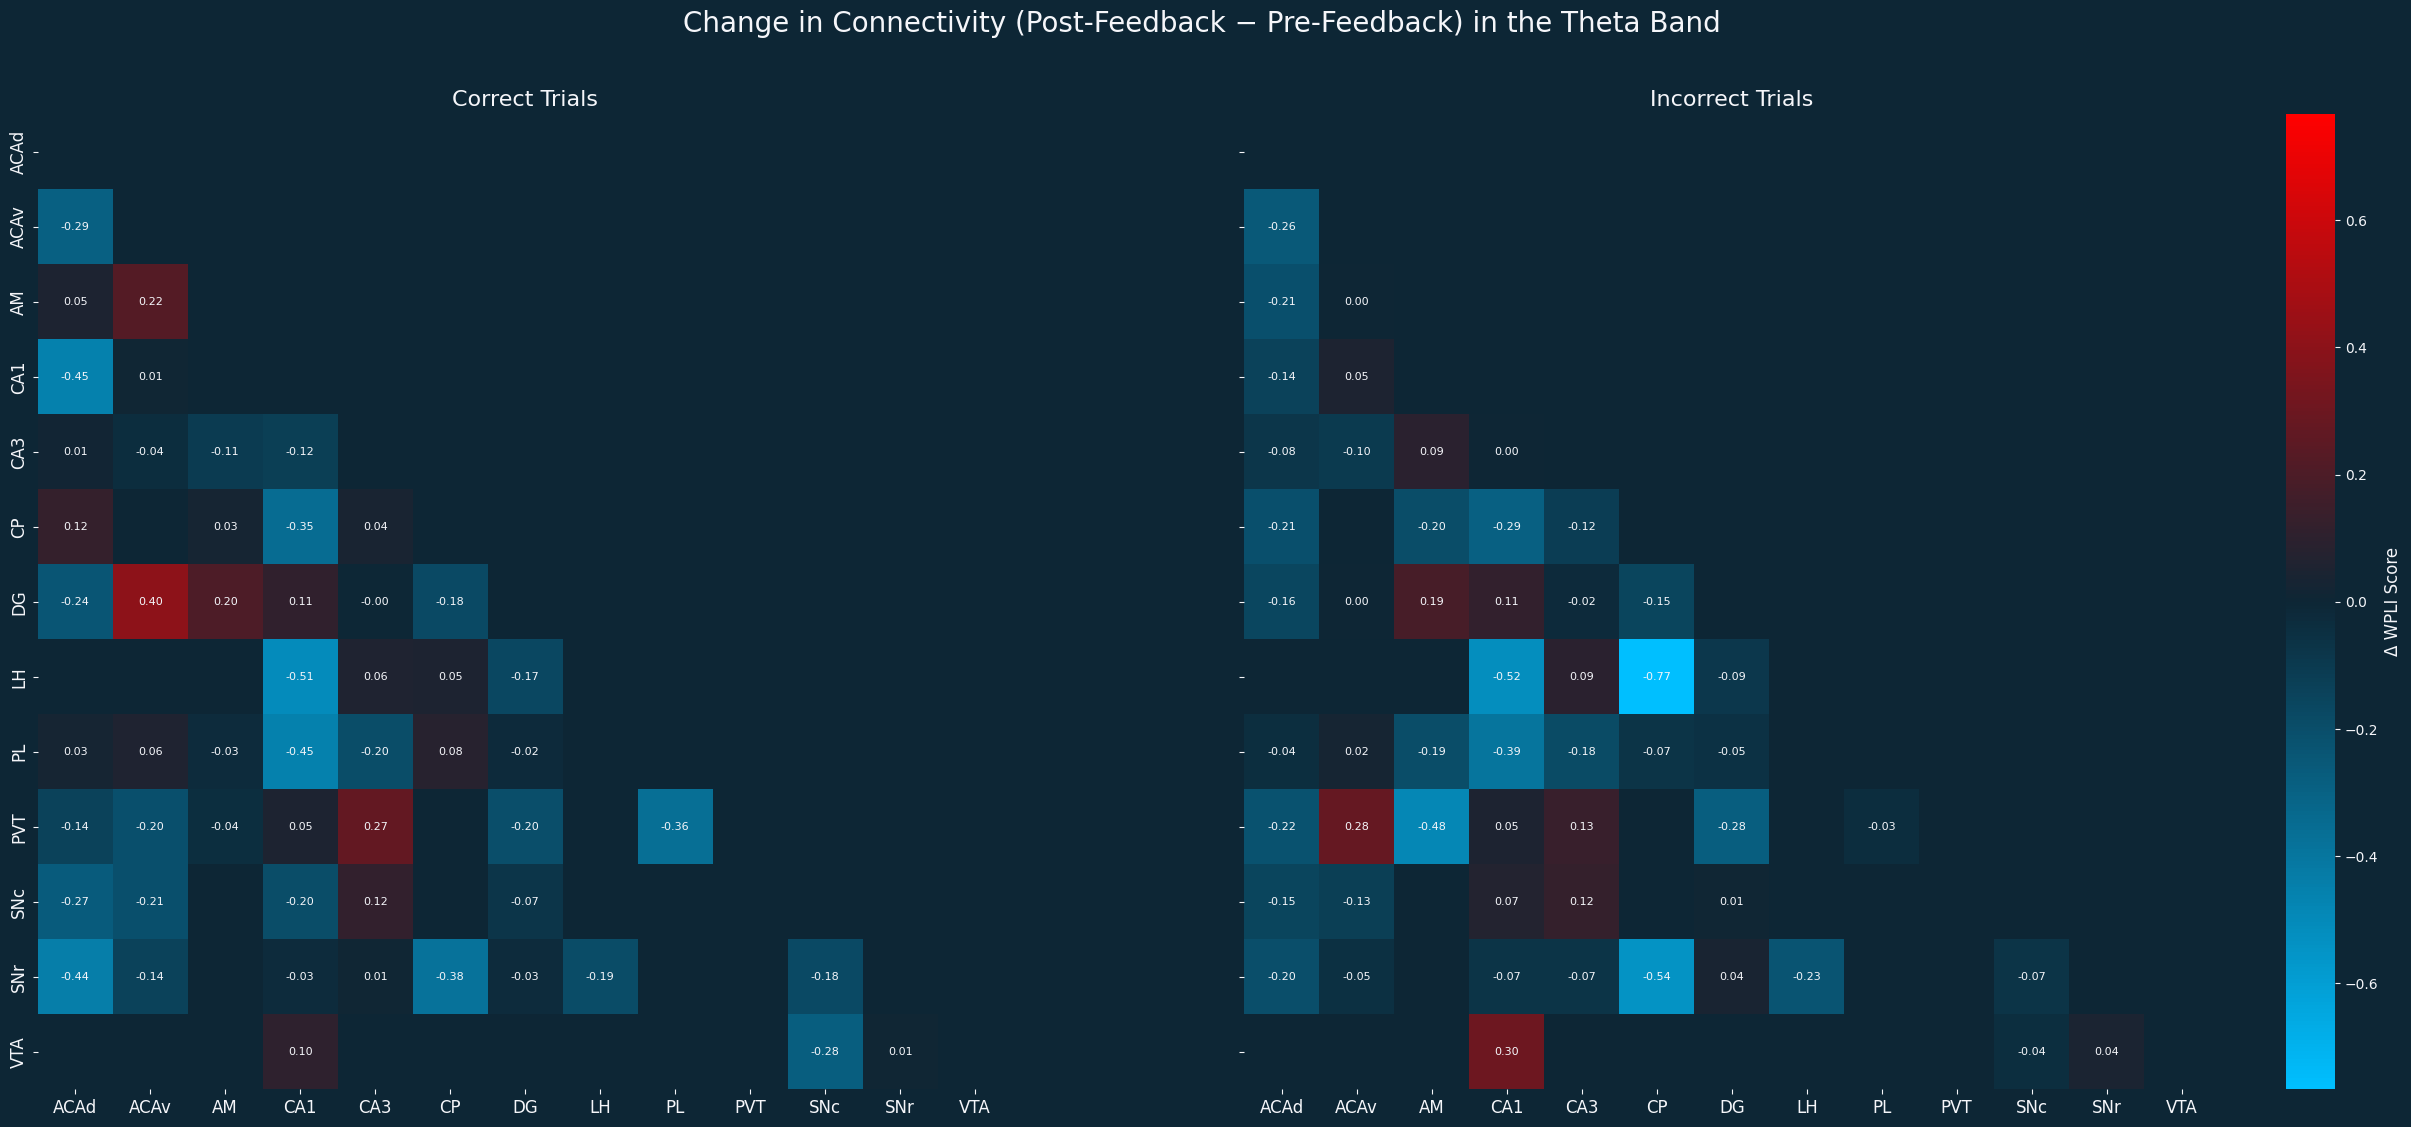

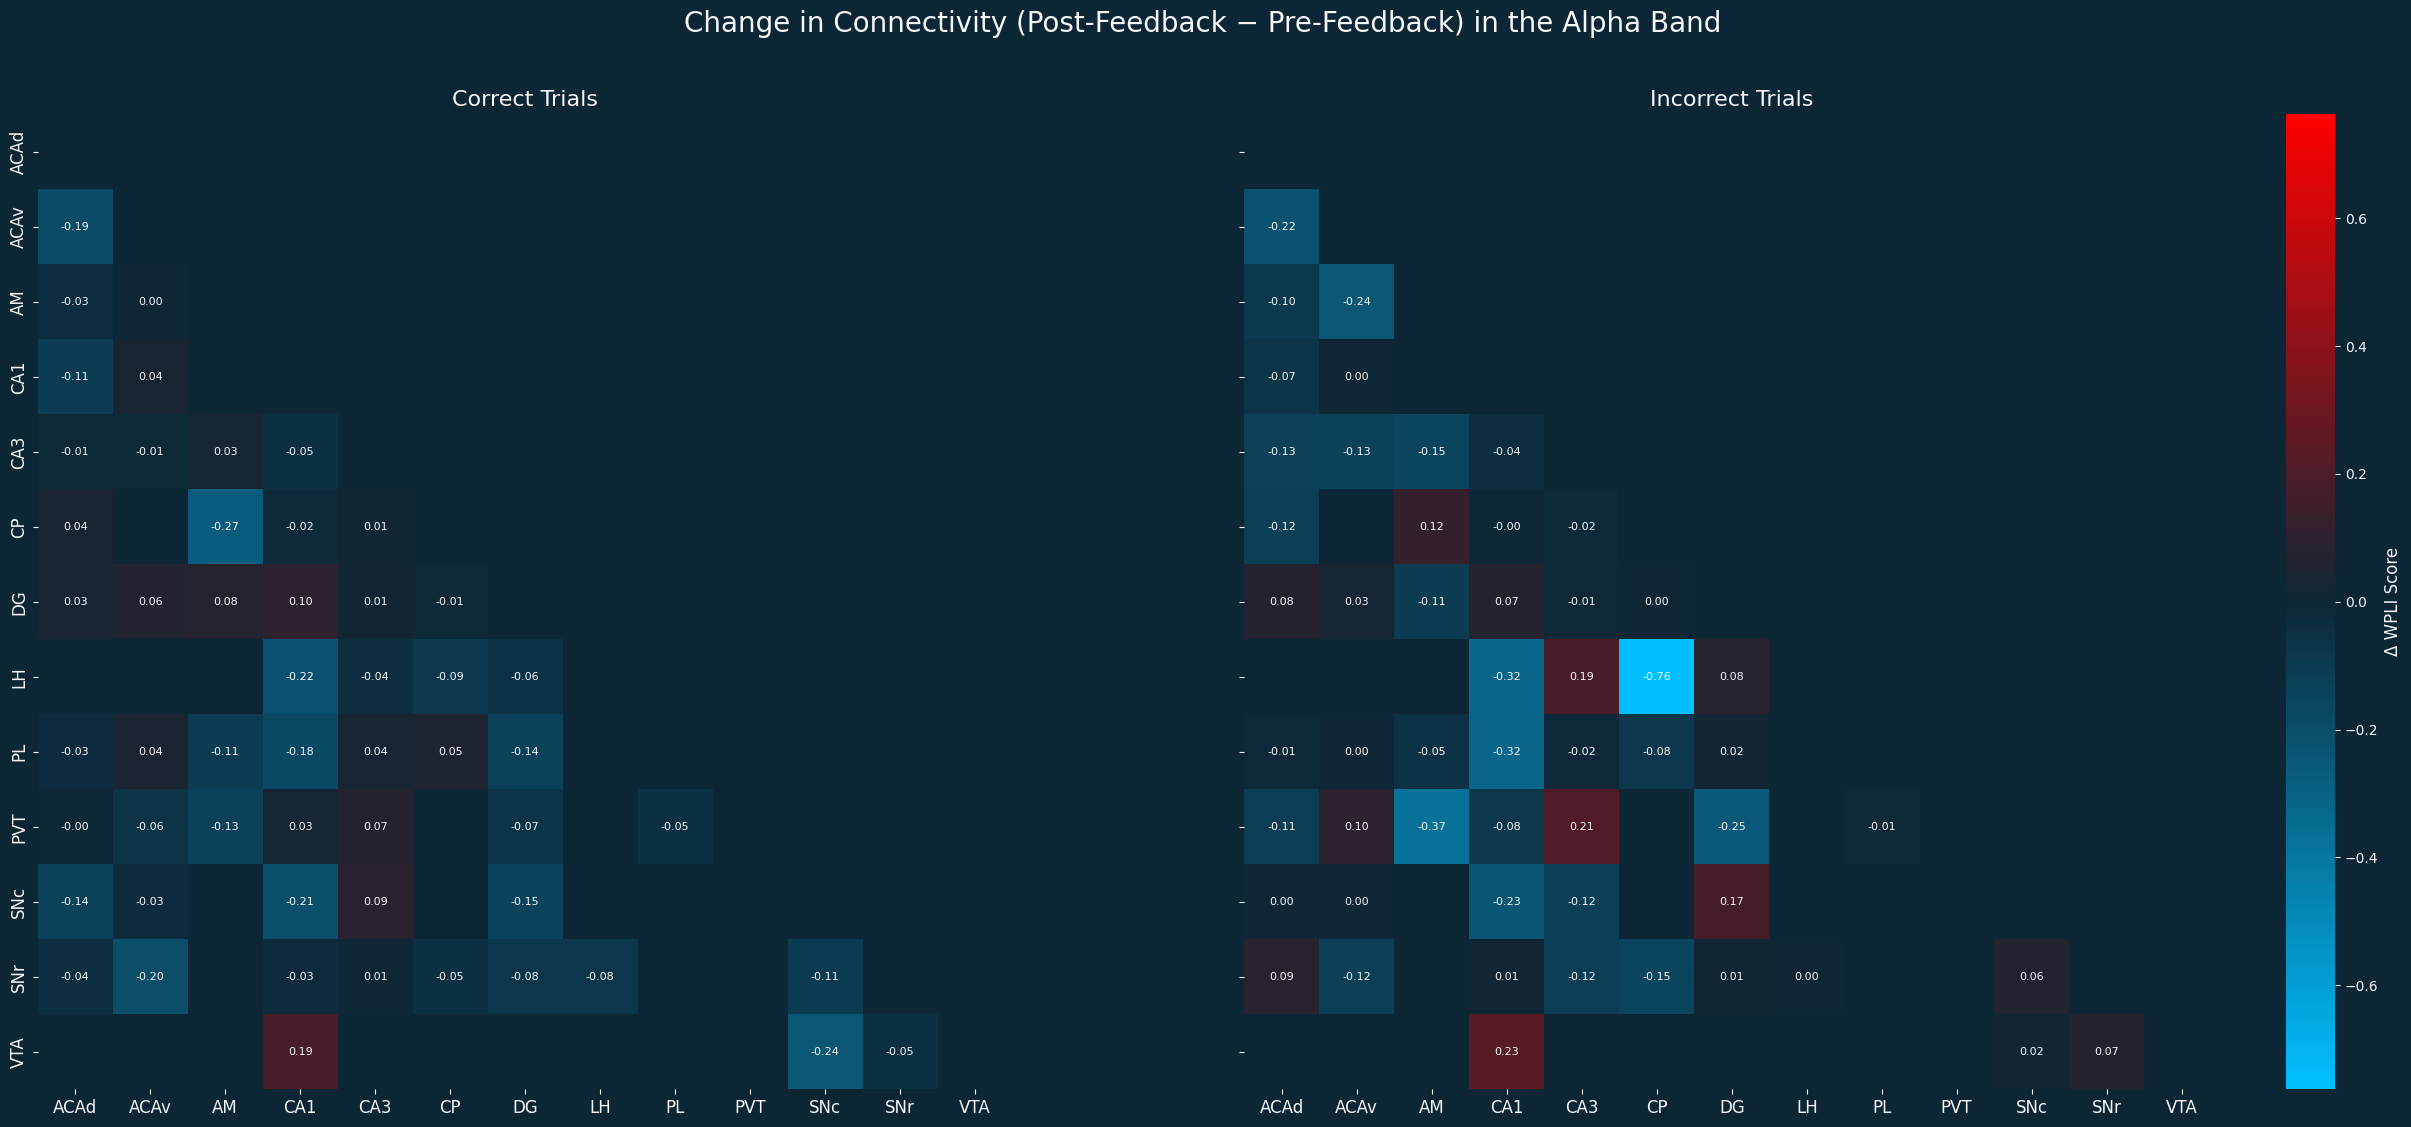

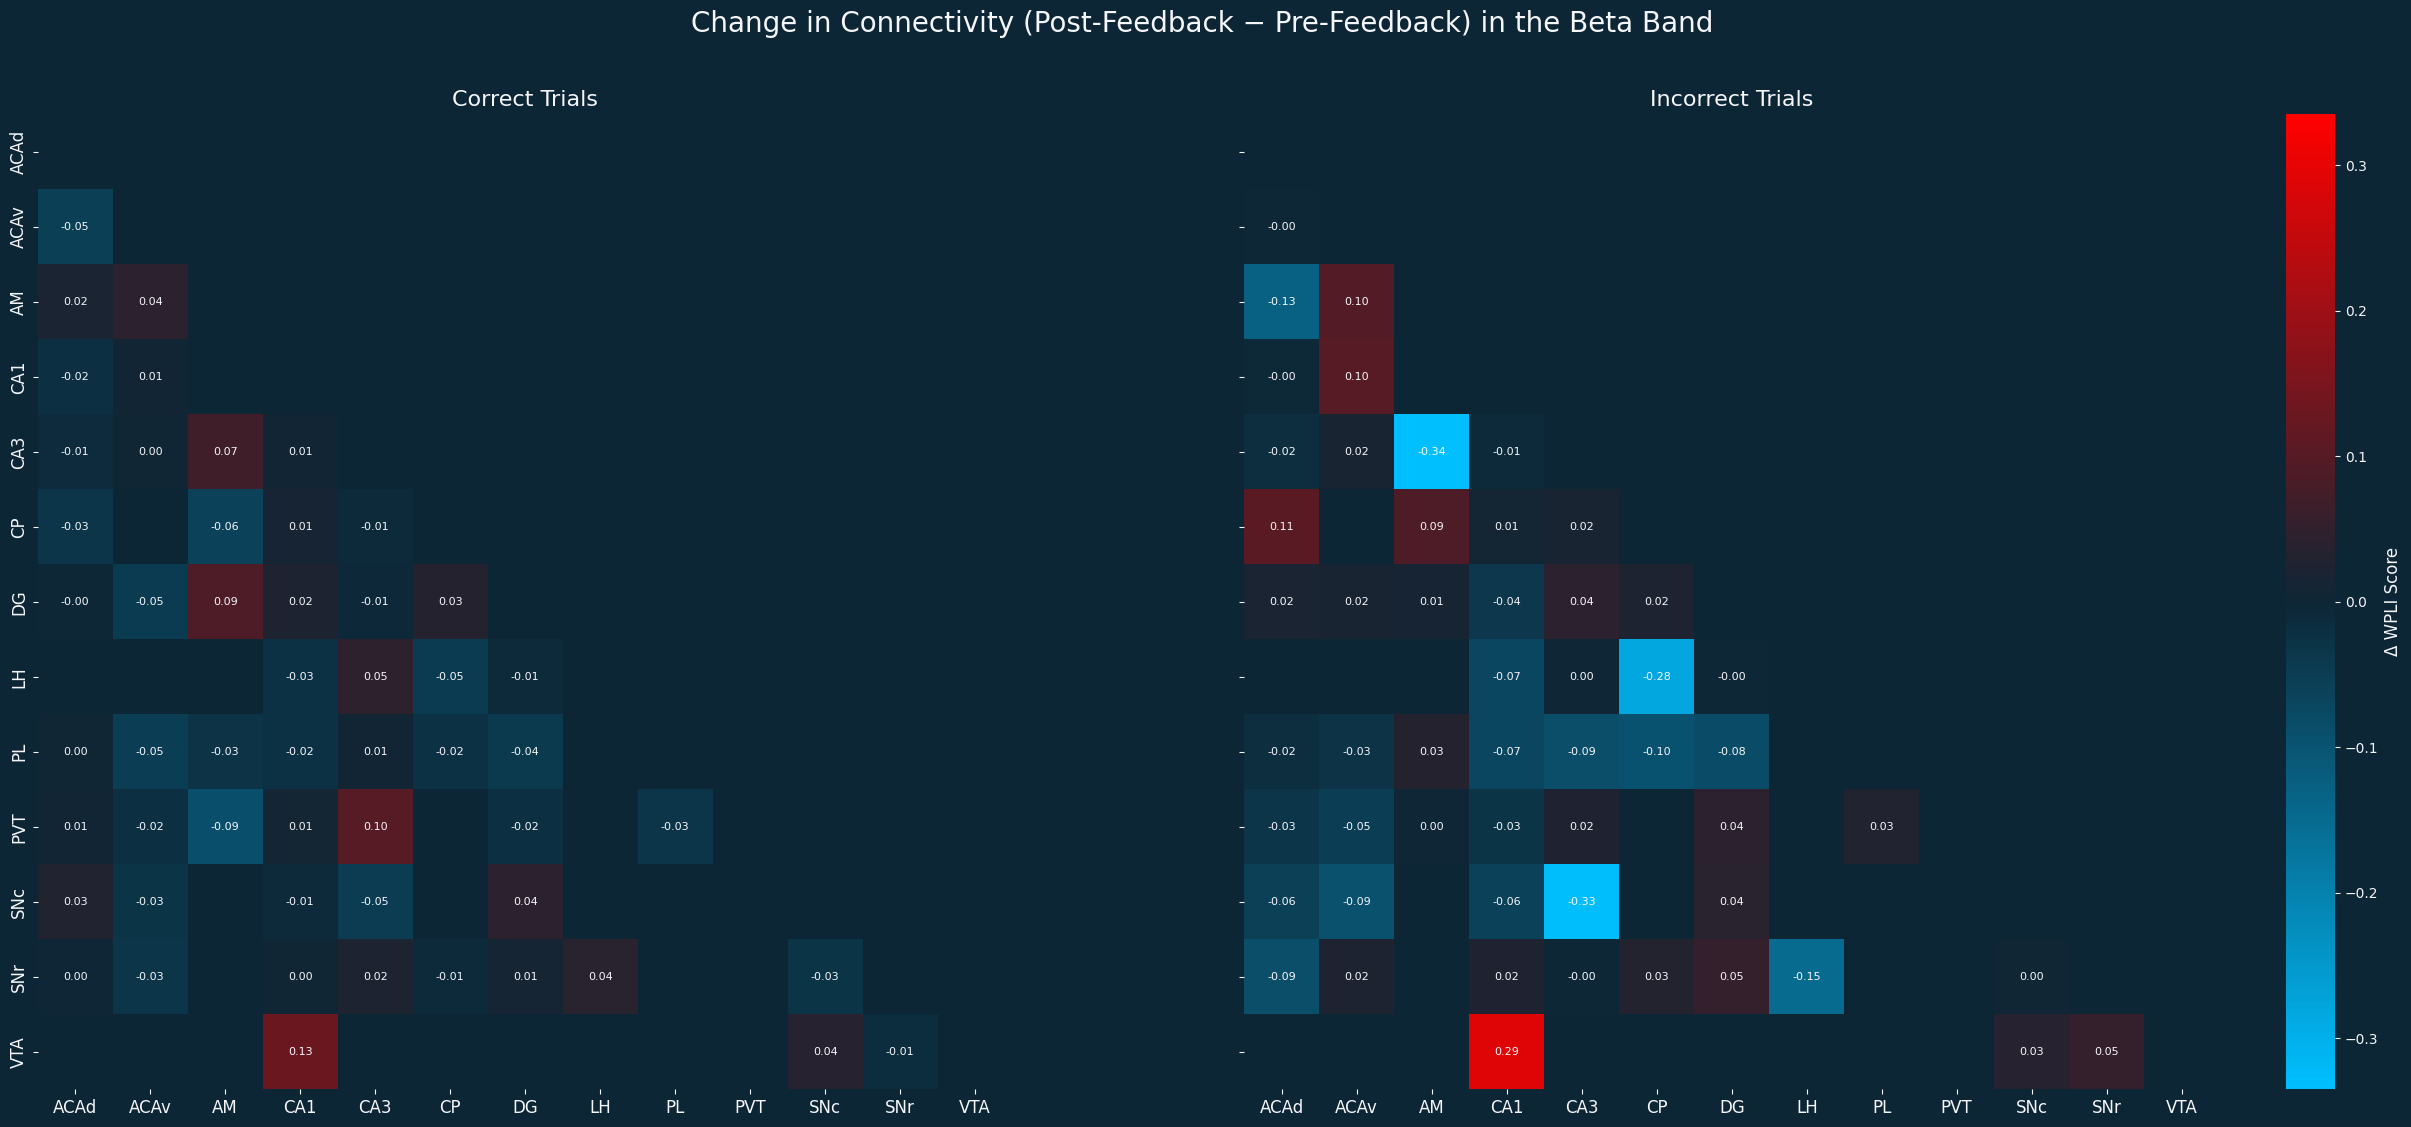

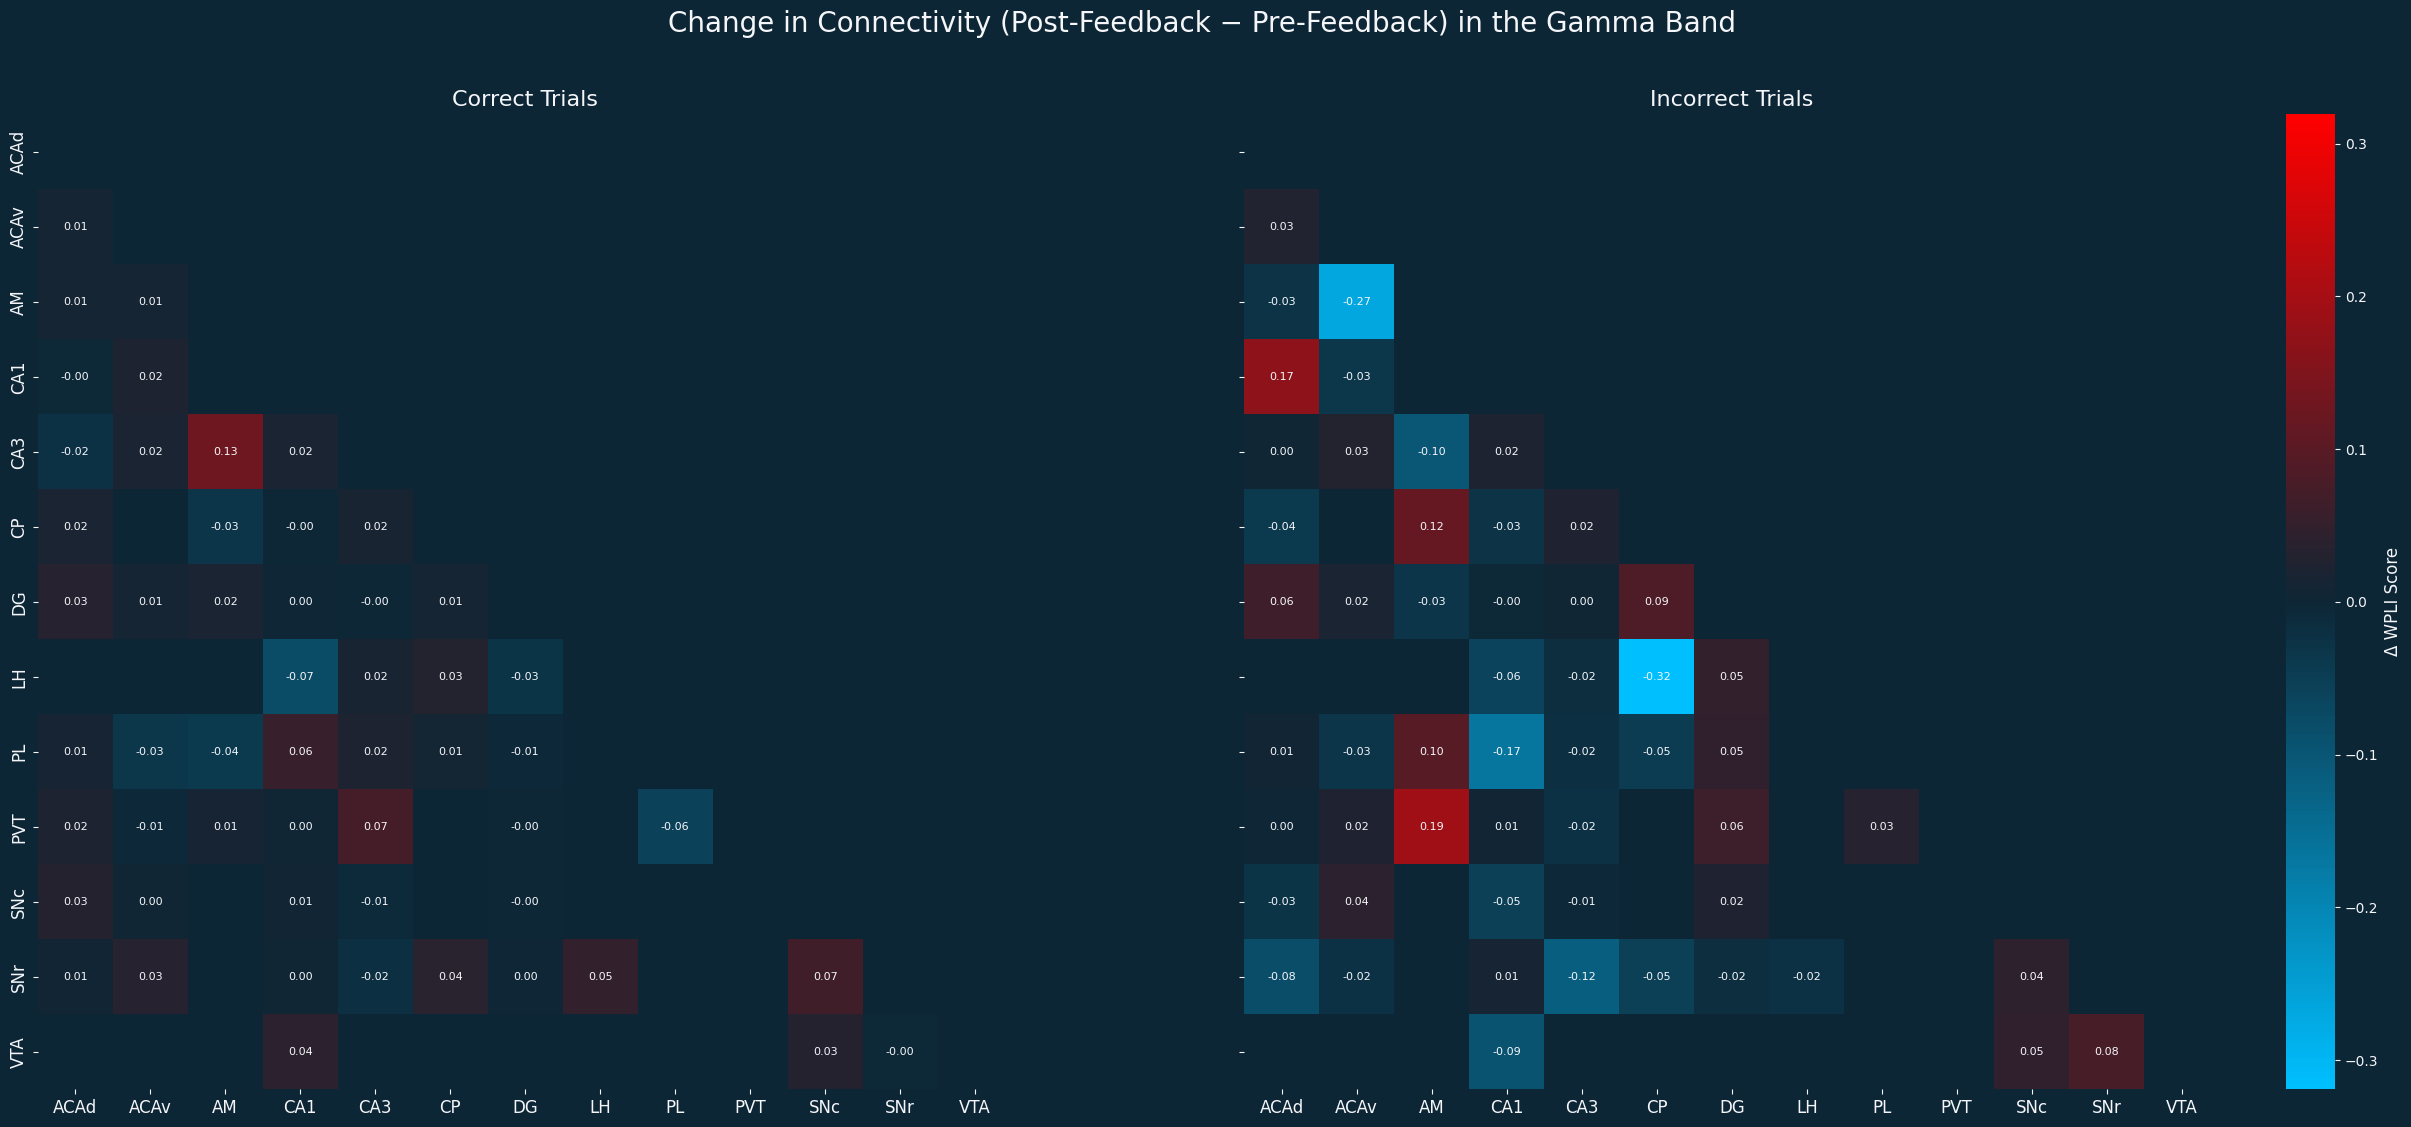

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap

# Dark mode colors
dark_bg_color = "#0d2635"
light_text_color = "#f5f6fa"

# Custom colormap: blue to dark to red
cmap_blue_crimson = LinearSegmentedColormap.from_list(
    "custom_blue_crimson",
    ["#00bfff", "#0d2635", "#FF0000"]
)
cmap = cmap_blue_crimson

# List of ROIs with connectivity data
all_rois_with_data = sorted(list(set([roi for pair in connectivity_results['correct'].keys() for roi in pair])))

# Plot for each frequency band
for band_name in freq_bands.keys():
    
    # Delta matrices for correct/incorrect trials
    correct_delta_matrix = pd.DataFrame(np.nan, index=all_rois_with_data, columns=all_rois_with_data)
    incorrect_delta_matrix = pd.DataFrame(np.nan, index=all_rois_with_data, columns=all_rois_with_data)

    # Fill correct delta matrix
    for pair, band_scores in connectivity_results['correct'].items():
        if band_name in band_scores:
            r1, r2 = pair
            delta_score = band_scores[band_name]['post_feedback'] - band_scores[band_name]['pre_feedback']
            correct_delta_matrix.loc[r1, r2] = delta_score
            correct_delta_matrix.loc[r2, r1] = delta_score

    # Fill incorrect delta matrix
    for pair, band_scores in connectivity_results['incorrect'].items():
        if band_name in band_scores:
            r1, r2 = pair
            delta_score = band_scores[band_name]['post_feedback'] - band_scores[band_name]['pre_feedback']
            incorrect_delta_matrix.loc[r1, r2] = delta_score
            incorrect_delta_matrix.loc[r2, r1] = delta_score
            
    # Upper triangle mask
    mask = np.triu(np.ones_like(correct_delta_matrix, dtype=bool))
    
    plt.style.use('dark_background')
    
    # Symmetric color scale
    max_abs_val = max(abs(correct_delta_matrix.min().min()), abs(correct_delta_matrix.max().max()),
                      abs(incorrect_delta_matrix.min().min()), abs(incorrect_delta_matrix.max().max()))
    
    fig, axes = plt.subplots(1, 2, figsize=(26, 11), sharey=True,
                           gridspec_kw={"width_ratios": [1, 1.15]})
    
    fig.patch.set_facecolor(dark_bg_color)
    axes[0].set_facecolor(dark_bg_color)
    axes[1].set_facecolor(dark_bg_color)

    fig.suptitle(f"Change in Connectivity (Post-Feedback − Pre-Feedback) in the {band_name} Band", 
                 fontsize=20, y=1.02, color=light_text_color)

    # Heatmap: correct trials
    sns.heatmap(correct_delta_matrix, ax=axes[0], mask=mask, annot=True, 
                fmt='.2f', cmap=cmap,
                vmin=-max_abs_val, vmax=max_abs_val, square=True,
                annot_kws={"color": light_text_color, "size": 8},
                cbar=False)
    axes[0].set_title('Correct Trials', fontsize=16, color=light_text_color)

    # Heatmap: incorrect trials
    sns.heatmap(incorrect_delta_matrix, ax=axes[1], mask=mask, annot=True,
                fmt='.2f', cmap=cmap,
                vmin=-max_abs_val, vmax=max_abs_val, square=True,
                annot_kws={"color": light_text_color, "size": 8},
                cbar_kws={'label': 'Δ WPLI Score'})
    axes[1].set_title('Incorrect Trials', fontsize=16, color=light_text_color)
    
    # Style ticks and colorbar
    for ax in axes:
        ax.tick_params(axis='x', colors=light_text_color, labelsize=12)
        ax.tick_params(axis='y', colors=light_text_color, labelsize=12)

    cbar = axes[1].collections[0].colorbar
    cbar.ax.yaxis.label.set_color(light_text_color)
    cbar.ax.yaxis.label.set_size(12)
    cbar.ax.tick_params(colors=light_text_color, labelsize=10)

    plt.tight_layout(w_pad=3)
    plt.show()

plt.style.use('default')


### **Permutation Testing**

In [ ]:
#Parameters
sfreq = 1 / meta_feedback['dt']
freq_bands = {
    'Theta': [4, 8], 'Alpha': [8, 13], 'Beta': [13, 30], 'Gamma': [30, 45]
}
fmin = [val[0] for val in freq_bands.values()]
fmax = [val[1] for val in freq_bands.values()]
pre_feedback_window = [0.0, 0.5]
post_feedback_window = [0.5, 1.5]

N_PERMUTATIONS = 1000
results_correct_list = []
results_incorrect_list = []

print(f"Starting pre- vs. post-feedback permutation testing with {N_PERMUTATIONS} permutations...")

# WPLI calculation for a time window
def calculate_wpli(data, tmin, tmax):
    if data.shape[0] < 2:
        return np.zeros(len(fmin))
    con = mne_connectivity.spectral_connectivity_epochs(
        data, method='wpli', mode='multitaper', sfreq=sfreq,
        fmin=fmin, fmax=fmax, faverage=True, tmin=tmin, tmax=tmax,
        verbose=False).get_data(output='dense')[1, 0]
    return con

# Main loop: pairs and conditions
for pair, outcomes in tqdm(connectivity_data.items(), desc="Processing Pairs"):
    region_a, region_b = pair

    for condition in ['correct', 'incorrect']:
        if not outcomes[condition][region_a]:
            continue

        # Aggregate trials
        all_trials_a = np.concatenate(outcomes[condition][region_a], axis=0)
        all_trials_b = np.concatenate(outcomes[condition][region_b], axis=0)

        if all_trials_a.shape[0] < 10:
            continue

        # Stack trials for MNE
        data_all_trials = np.stack([all_trials_a, all_trials_b], axis=1)
        n_trials = data_all_trials.shape[0]

        # Observed difference
        wpli_pre_obs = calculate_wpli(data_all_trials, pre_feedback_window[0], pre_feedback_window[1])
        wpli_post_obs = calculate_wpli(data_all_trials, post_feedback_window[0], post_feedback_window[1])
        observed_diff = wpli_post_obs - wpli_pre_obs

        # Permutations
        permuted_diffs = np.zeros((N_PERMUTATIONS, len(fmin)))
        times = meta_feedback['times']
        pre_indices = (times >= pre_feedback_window[0]) & (times < pre_feedback_window[1])
        post_indices = (times >= post_feedback_window[0]) & (times < post_feedback_window[1])
        data_pre_window = data_all_trials[:, :, pre_indices]
        data_post_window = data_all_trials[:, :, post_indices]

        for i in range(N_PERMUTATIONS):
            perm_data_pre = np.copy(data_pre_window)
            perm_data_post = np.copy(data_post_window)
            swap_decisions = np.random.rand(n_trials) > 0.5
            perm_data_pre[swap_decisions] = data_post_window[swap_decisions]
            perm_data_post[swap_decisions] = data_pre_window[swap_decisions]
            wpli_perm_pre = calculate_wpli(perm_data_pre, tmin=0, tmax=None)
            wpli_perm_post = calculate_wpli(perm_data_post, tmin=0, tmax=None)
            permuted_diffs[i, :] = wpli_perm_post - wpli_perm_pre

        # p-value calculation
        for i, band_name in enumerate(freq_bands.keys()):
            p_value = (np.sum(np.abs(permuted_diffs[:, i]) >= np.abs(observed_diff[i]))) / N_PERMUTATIONS
            result_entry = {
                'Pair': f"{region_a}-{region_b}",
                'Band': band_name,
                'p_value': p_value,
                'Observed_ΔWPLI': observed_diff[i],
                'N_trials': n_trials
            }
            if condition == 'correct':
                results_correct_list.append(result_entry)
            else:
                results_incorrect_list.append(result_entry)

print("\nPre- vs. post-feedback testing complete.")

# Show results
if results_correct_list:
    df_correct = pd.DataFrame(results_correct_list).sort_values(by='p_value', ascending=True)
    print("\n\n--- Change in Connectivity During CORRECT Trials (Post vs. Pre) ---")
    print("      (Sorted by Uncorrected p-value)")
    display(df_correct)
else:
    print("\n\n--- No results for CORRECT trials ---")

if results_incorrect_list:
    df_incorrect = pd.DataFrame(results_incorrect_list).sort_values(by='p_value', ascending=True)
    print("\n\n--- Change in Connectivity During INCORRECT Trials (Post vs. Pre) ---")
    print("      (Sorted by Uncorrected p-value)")
    display(df_incorrect)
else:
    print("\n\n--- No results for INCORRECT trials ---")


Starting pre- vs. post-feedback permutation testing with 1000 permutations...


Processing Pairs:   0%|          | 0/53 [00:00<?, ?it/s]


✅ Pre- vs. post-feedback testing complete.


--- Change in Connectivity During CORRECT Trials (Post vs. Pre) ---
      (Sorted by Uncorrected p-value)


,Pair,Band,p_value,Observed_ΔWPLI,N_trials
0,PL-PVT,Theta,0.000,-0.361513,284
4,PL-CA1,Theta,0.000,-0.449175,750
5,PL-CA1,Alpha,0.000,-0.178402,750
8,PL-CA3,Theta,0.000,-0.195560,734
13,PL-DG,Alpha,0.000,-0.136550,1313
...,...,...,...,...,...
103,SNc-ACAv,Gamma,0.954,0.003729,501
185,AM-ACAv,Alpha,0.964,0.004724,284
170,DG-ACAd,Beta,0.969,-0.000970,1246
49,PVT-ACAd,Alpha,0.974,-0.001254,1137




--- Change in Connectivity During INCORRECT Trials (Post vs. Pre) ---
      (Sorted by Uncorrected p-value)


,Pair,Band,p_value,Observed_ΔWPLI,N_trials
5,PL-CA1,Alpha,0.000,-0.318370,66
4,PL-CA1,Theta,0.000,-0.390595,66
10,PL-CA3,Beta,0.000,-0.088803,214
8,PL-CA3,Theta,0.000,-0.184196,214
14,PL-DG,Beta,0.000,-0.081702,168
...,...,...,...,...,...
46,PVT-AM,Beta,0.984,0.002111,49
51,PVT-ACAd,Gamma,0.984,0.001219,183
29,PL-ACAv,Alpha,0.985,0.002226,201
100,CA1-CA3,Theta,0.995,0.000141,3284


### **FDR Correction**

--- FDR Correction Results for Correct Trials ---


,Pair,Band,p_value,Observed_ΔWPLI,N_trials,q_value,Significant
0,PL-PVT,Theta,0.000,-0.361513,284,0.000000,True
4,PL-CA1,Theta,0.000,-0.449175,750,0.000000,True
5,PL-CA1,Alpha,0.000,-0.178402,750,0.000000,True
8,PL-CA3,Theta,0.000,-0.195560,734,0.000000,True
13,PL-DG,Alpha,0.000,-0.136550,1313,0.000000,True
...,...,...,...,...,...,...,...
103,SNc-ACAv,Gamma,0.954,0.003729,501,0.972346,False
185,AM-ACAv,Alpha,0.964,0.004724,284,0.977837,False
170,DG-ACAd,Beta,0.969,-0.000970,1246,0.978229,False
49,PVT-ACAd,Alpha,0.974,-0.001254,1137,0.978616,False



--- FDR Correction Results for Incorrect Trials ---


,Pair,Band,p_value,Observed_ΔWPLI,N_trials,q_value,Significant
5,PL-CA1,Alpha,0.000,-0.318370,66,0.000000,True
4,PL-CA1,Theta,0.000,-0.390595,66,0.000000,True
10,PL-CA3,Beta,0.000,-0.088803,214,0.000000,True
8,PL-CA3,Theta,0.000,-0.184196,214,0.000000,True
14,PL-DG,Beta,0.000,-0.081702,168,0.000000,True
...,...,...,...,...,...,...,...
46,PVT-AM,Beta,0.984,0.002111,49,0.994563,False
51,PVT-ACAd,Gamma,0.984,0.001219,183,0.994563,False
29,PL-ACAv,Alpha,0.985,0.002226,201,0.994563,False
100,CA1-CA3,Theta,0.995,0.000141,3284,0.996000,False


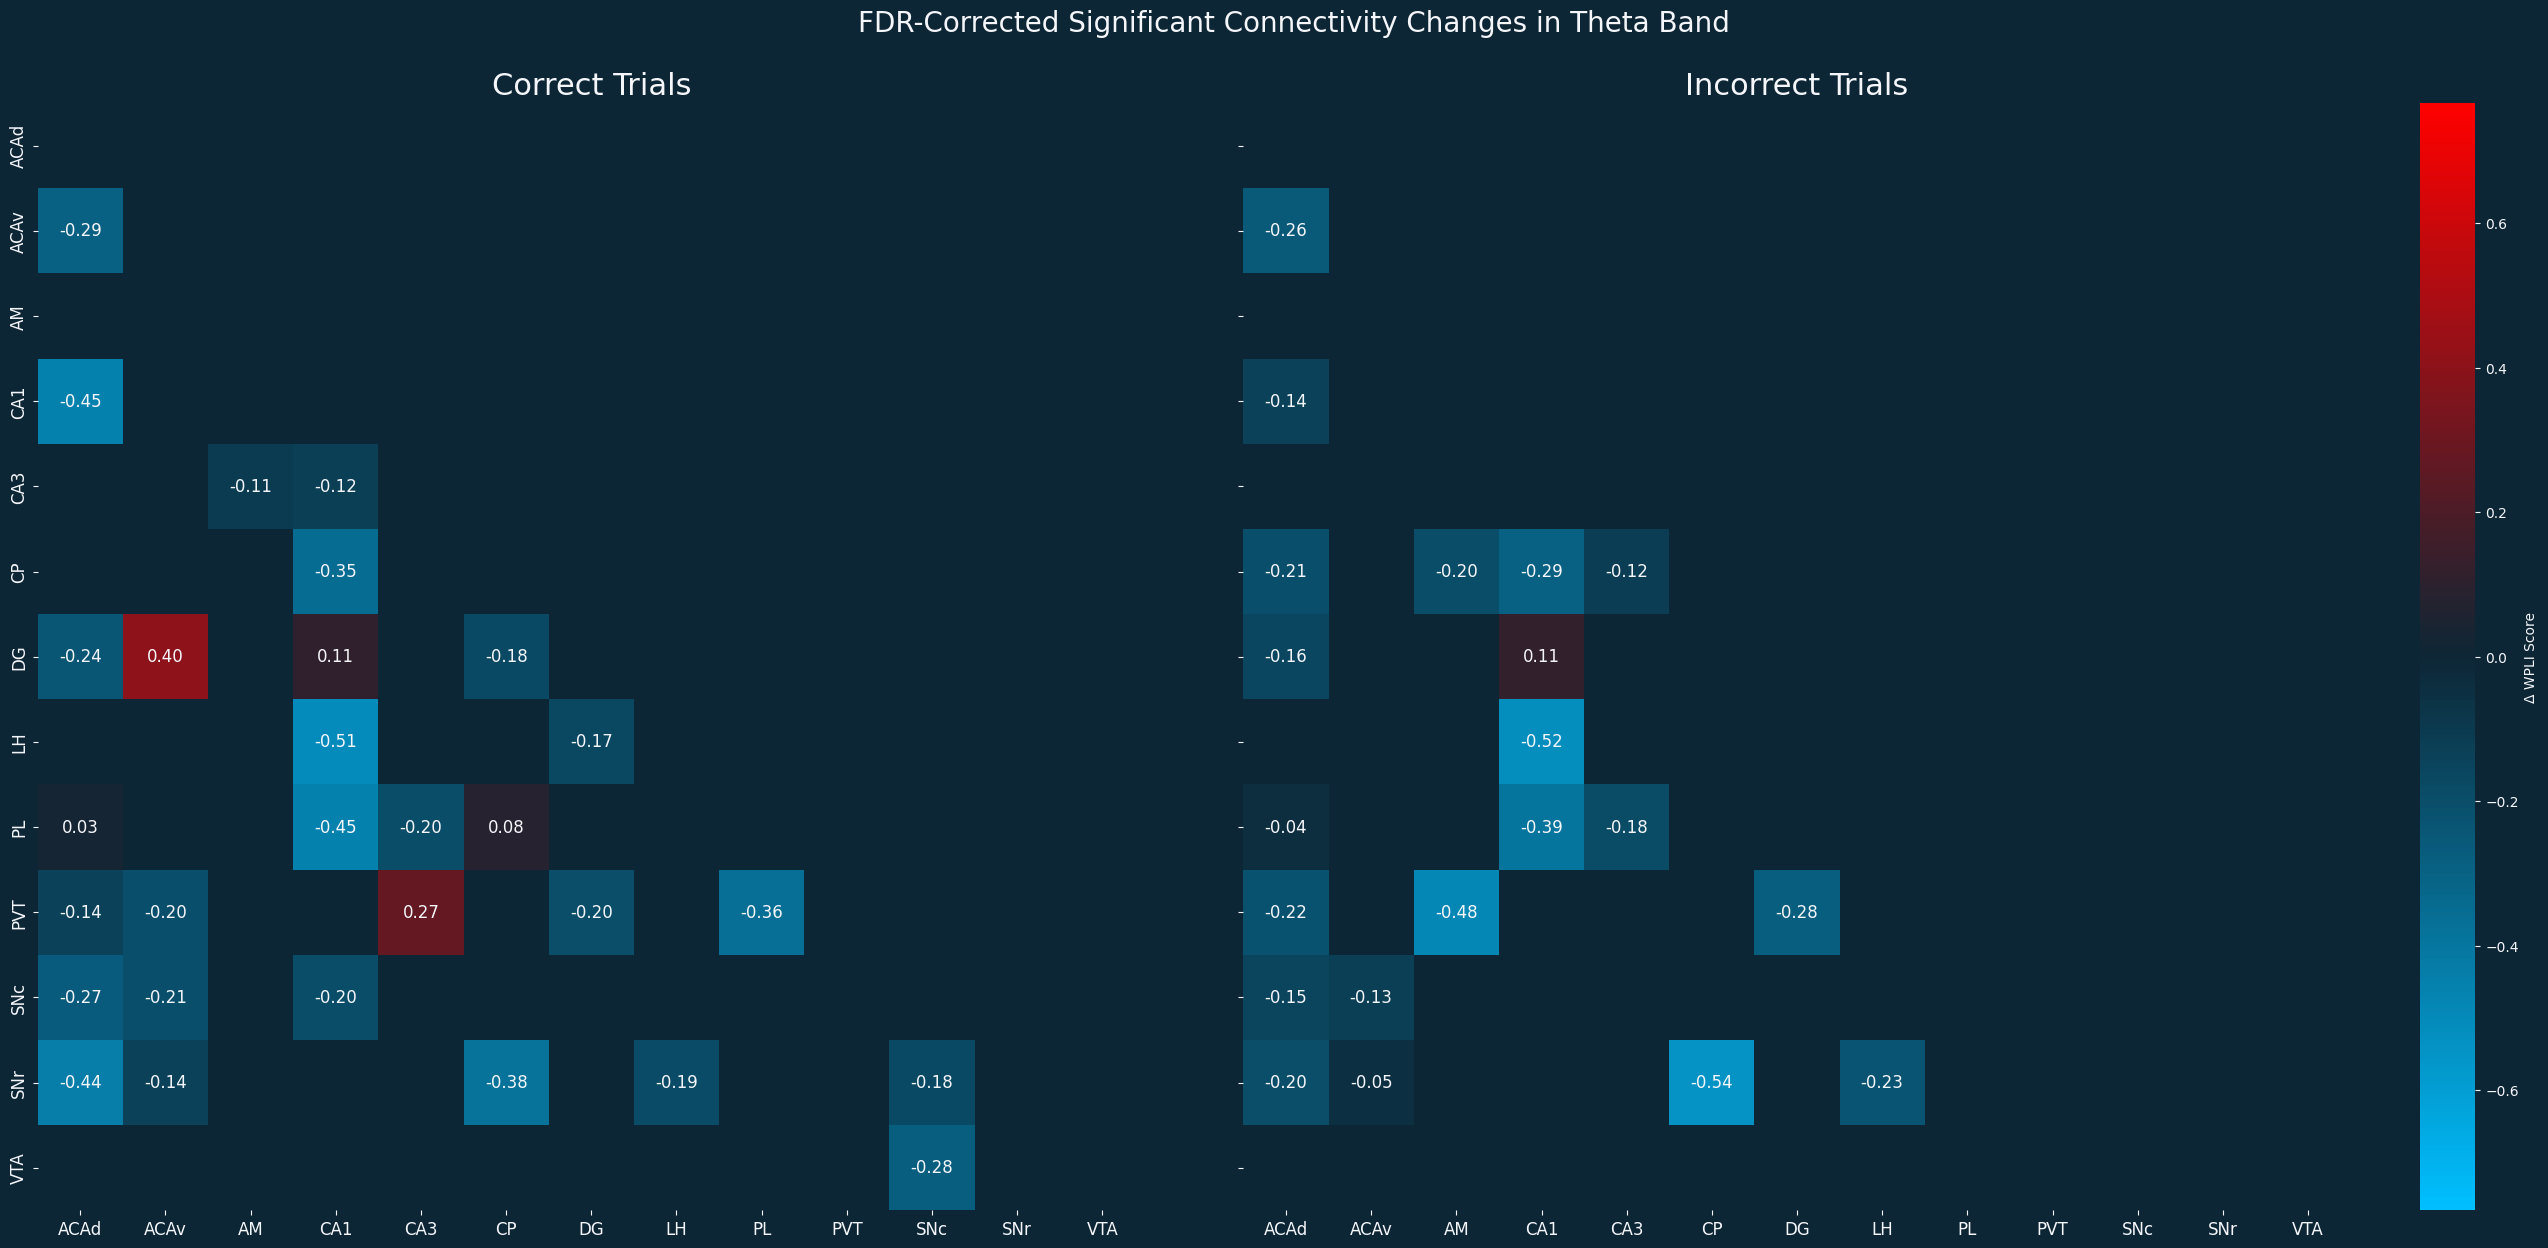

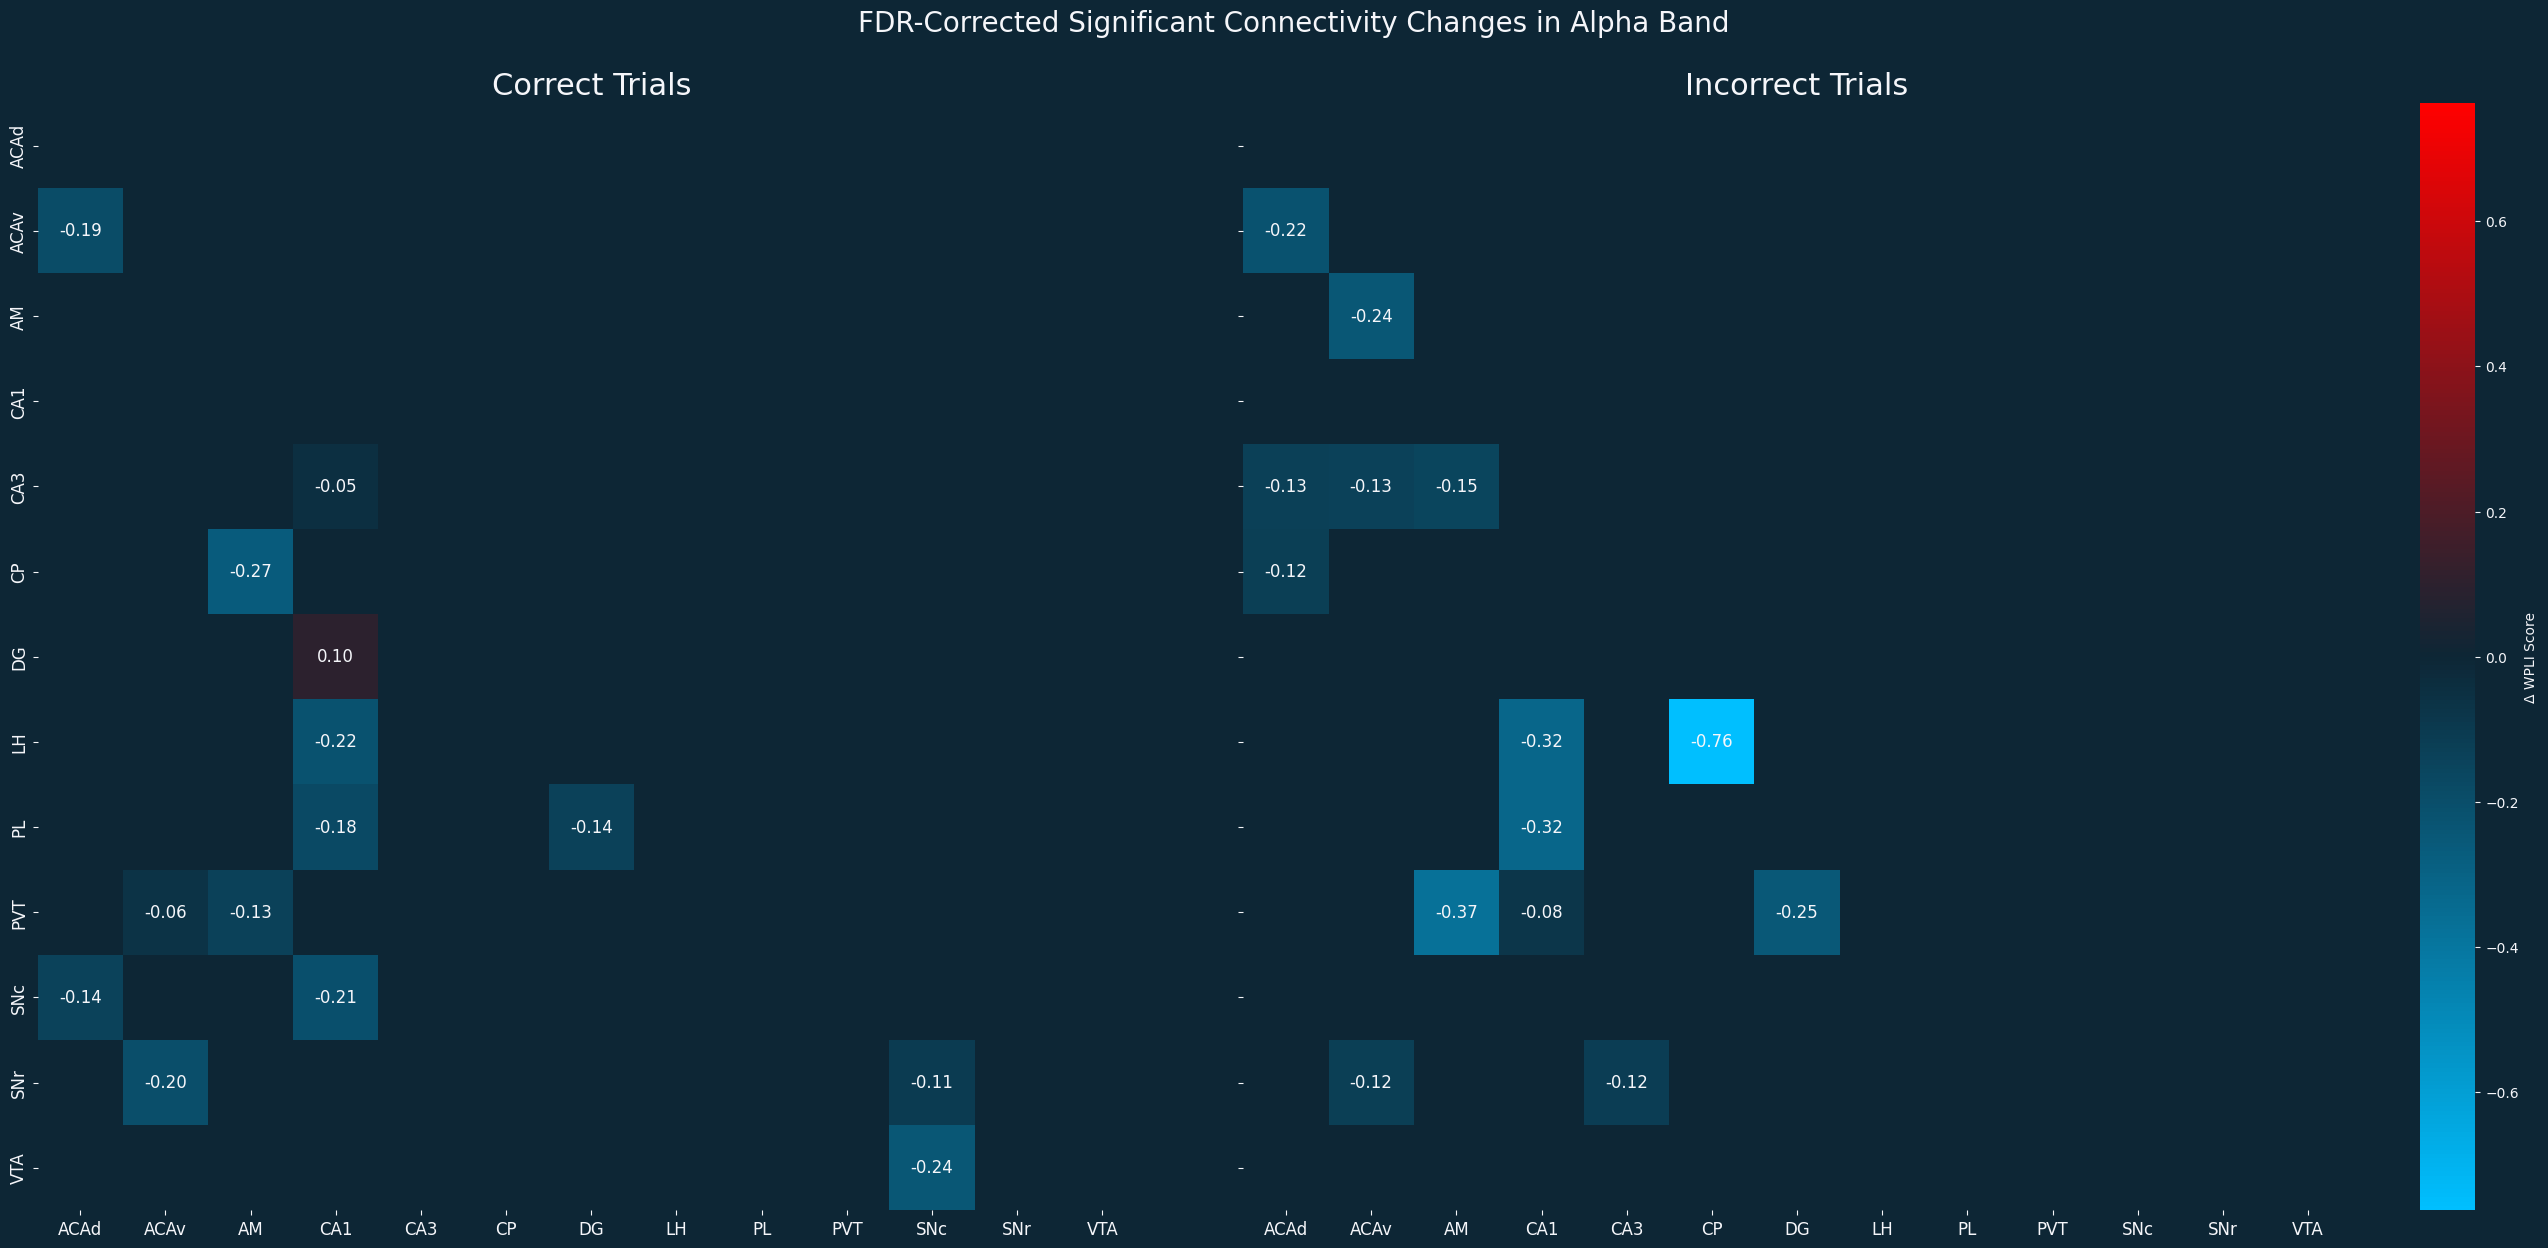

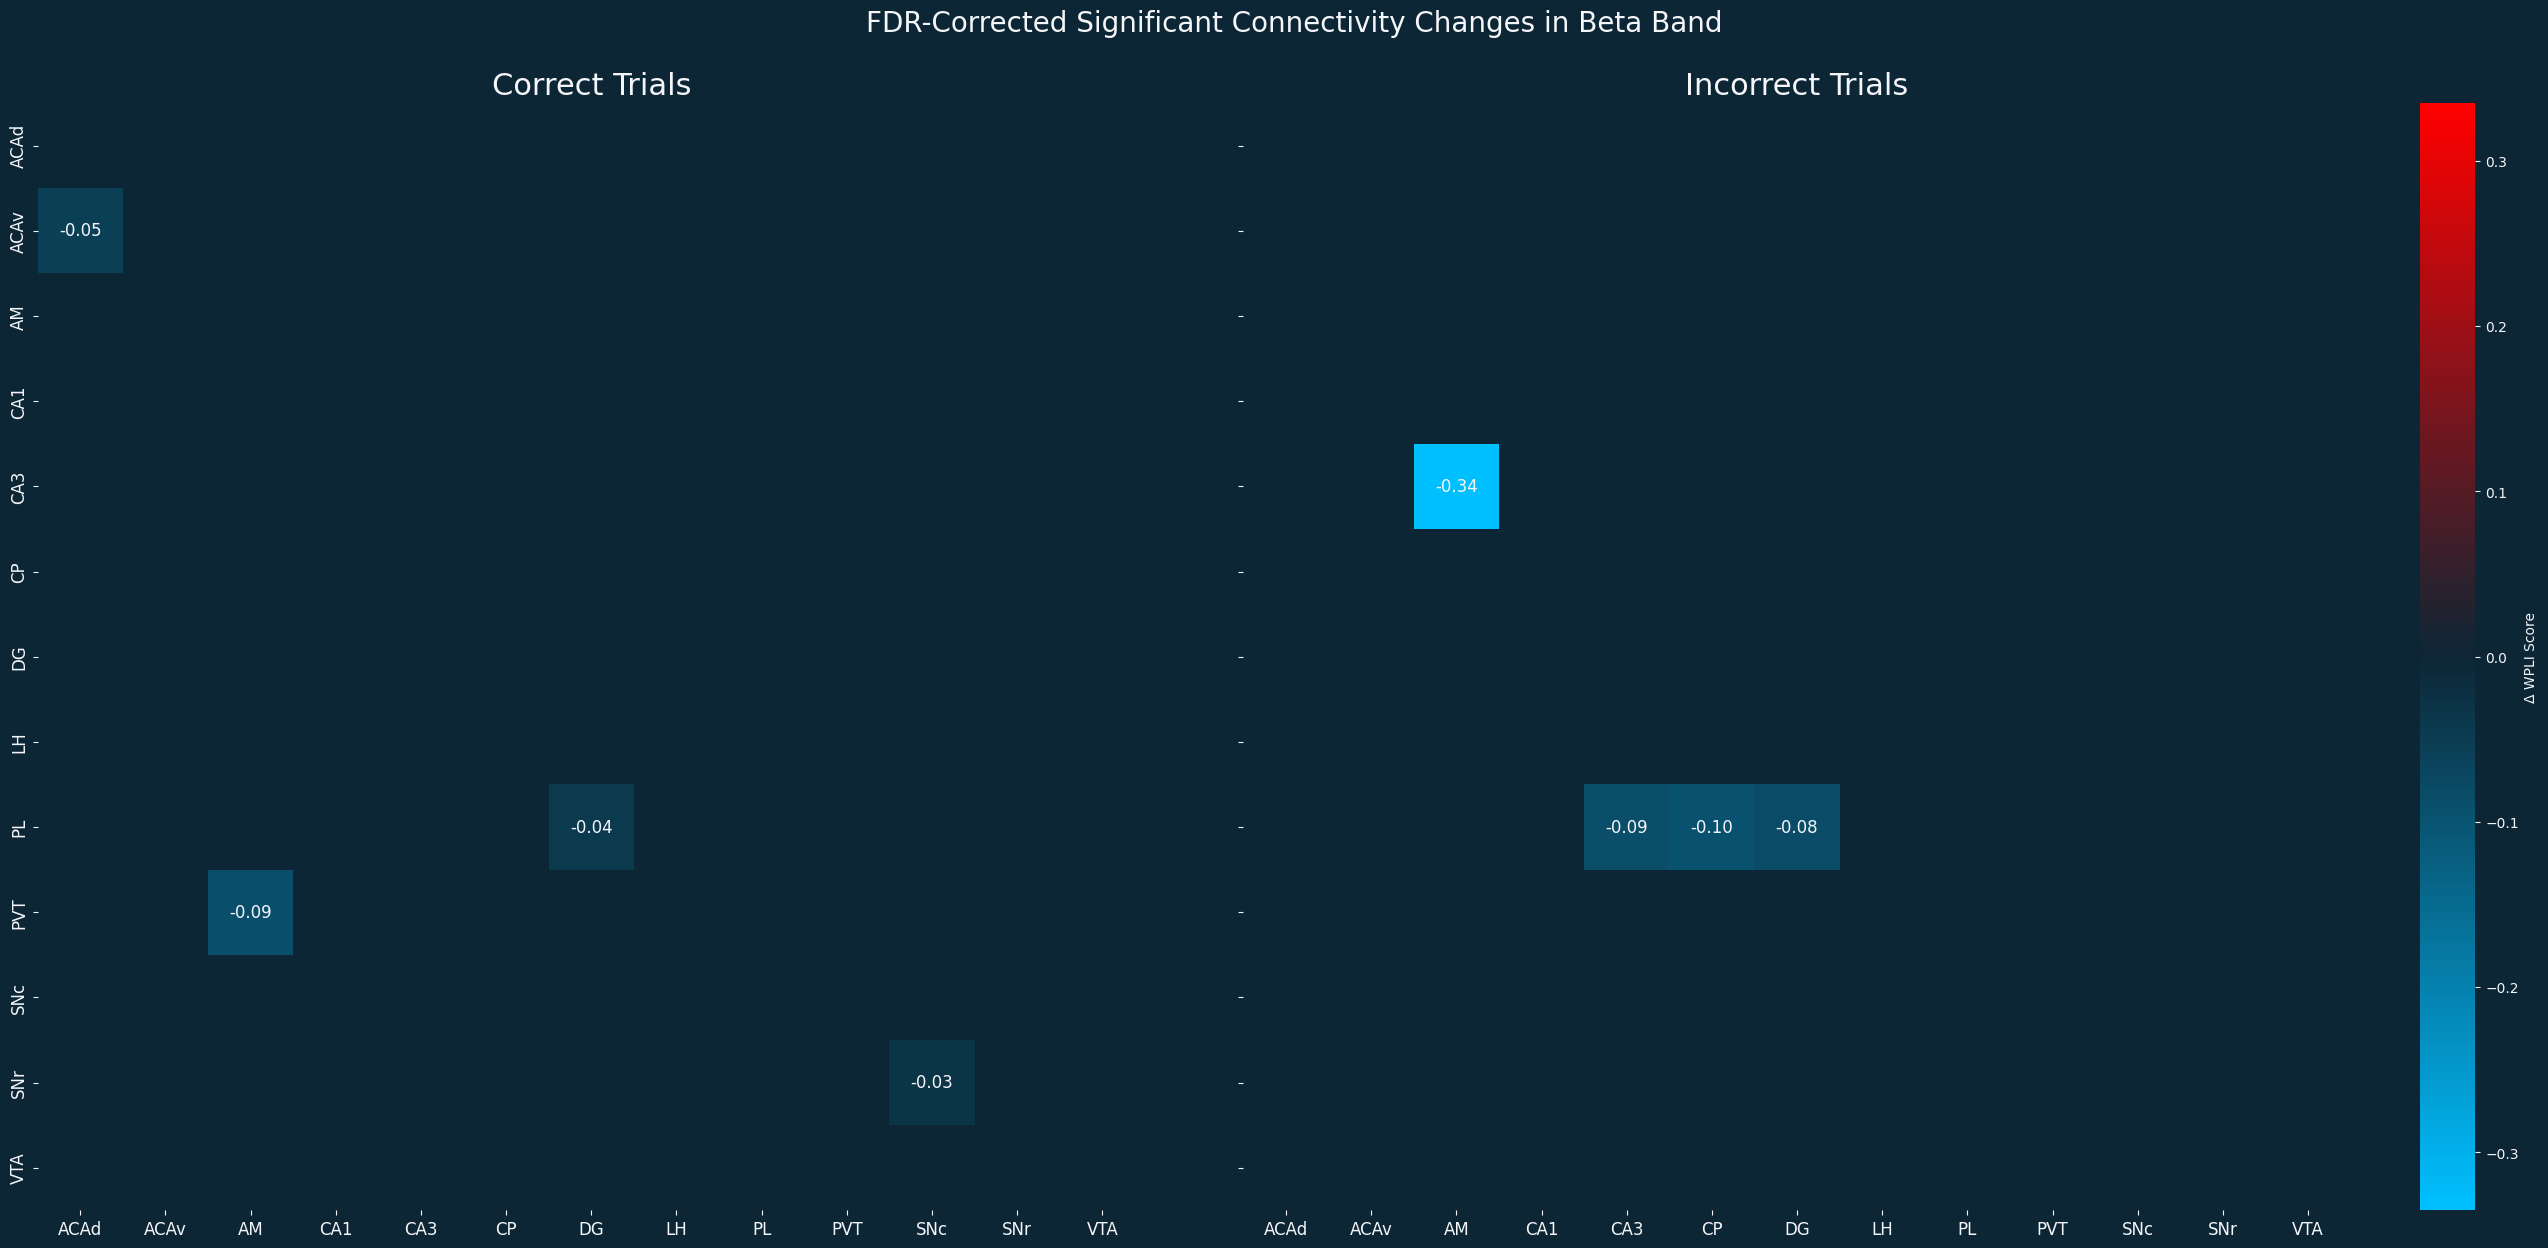

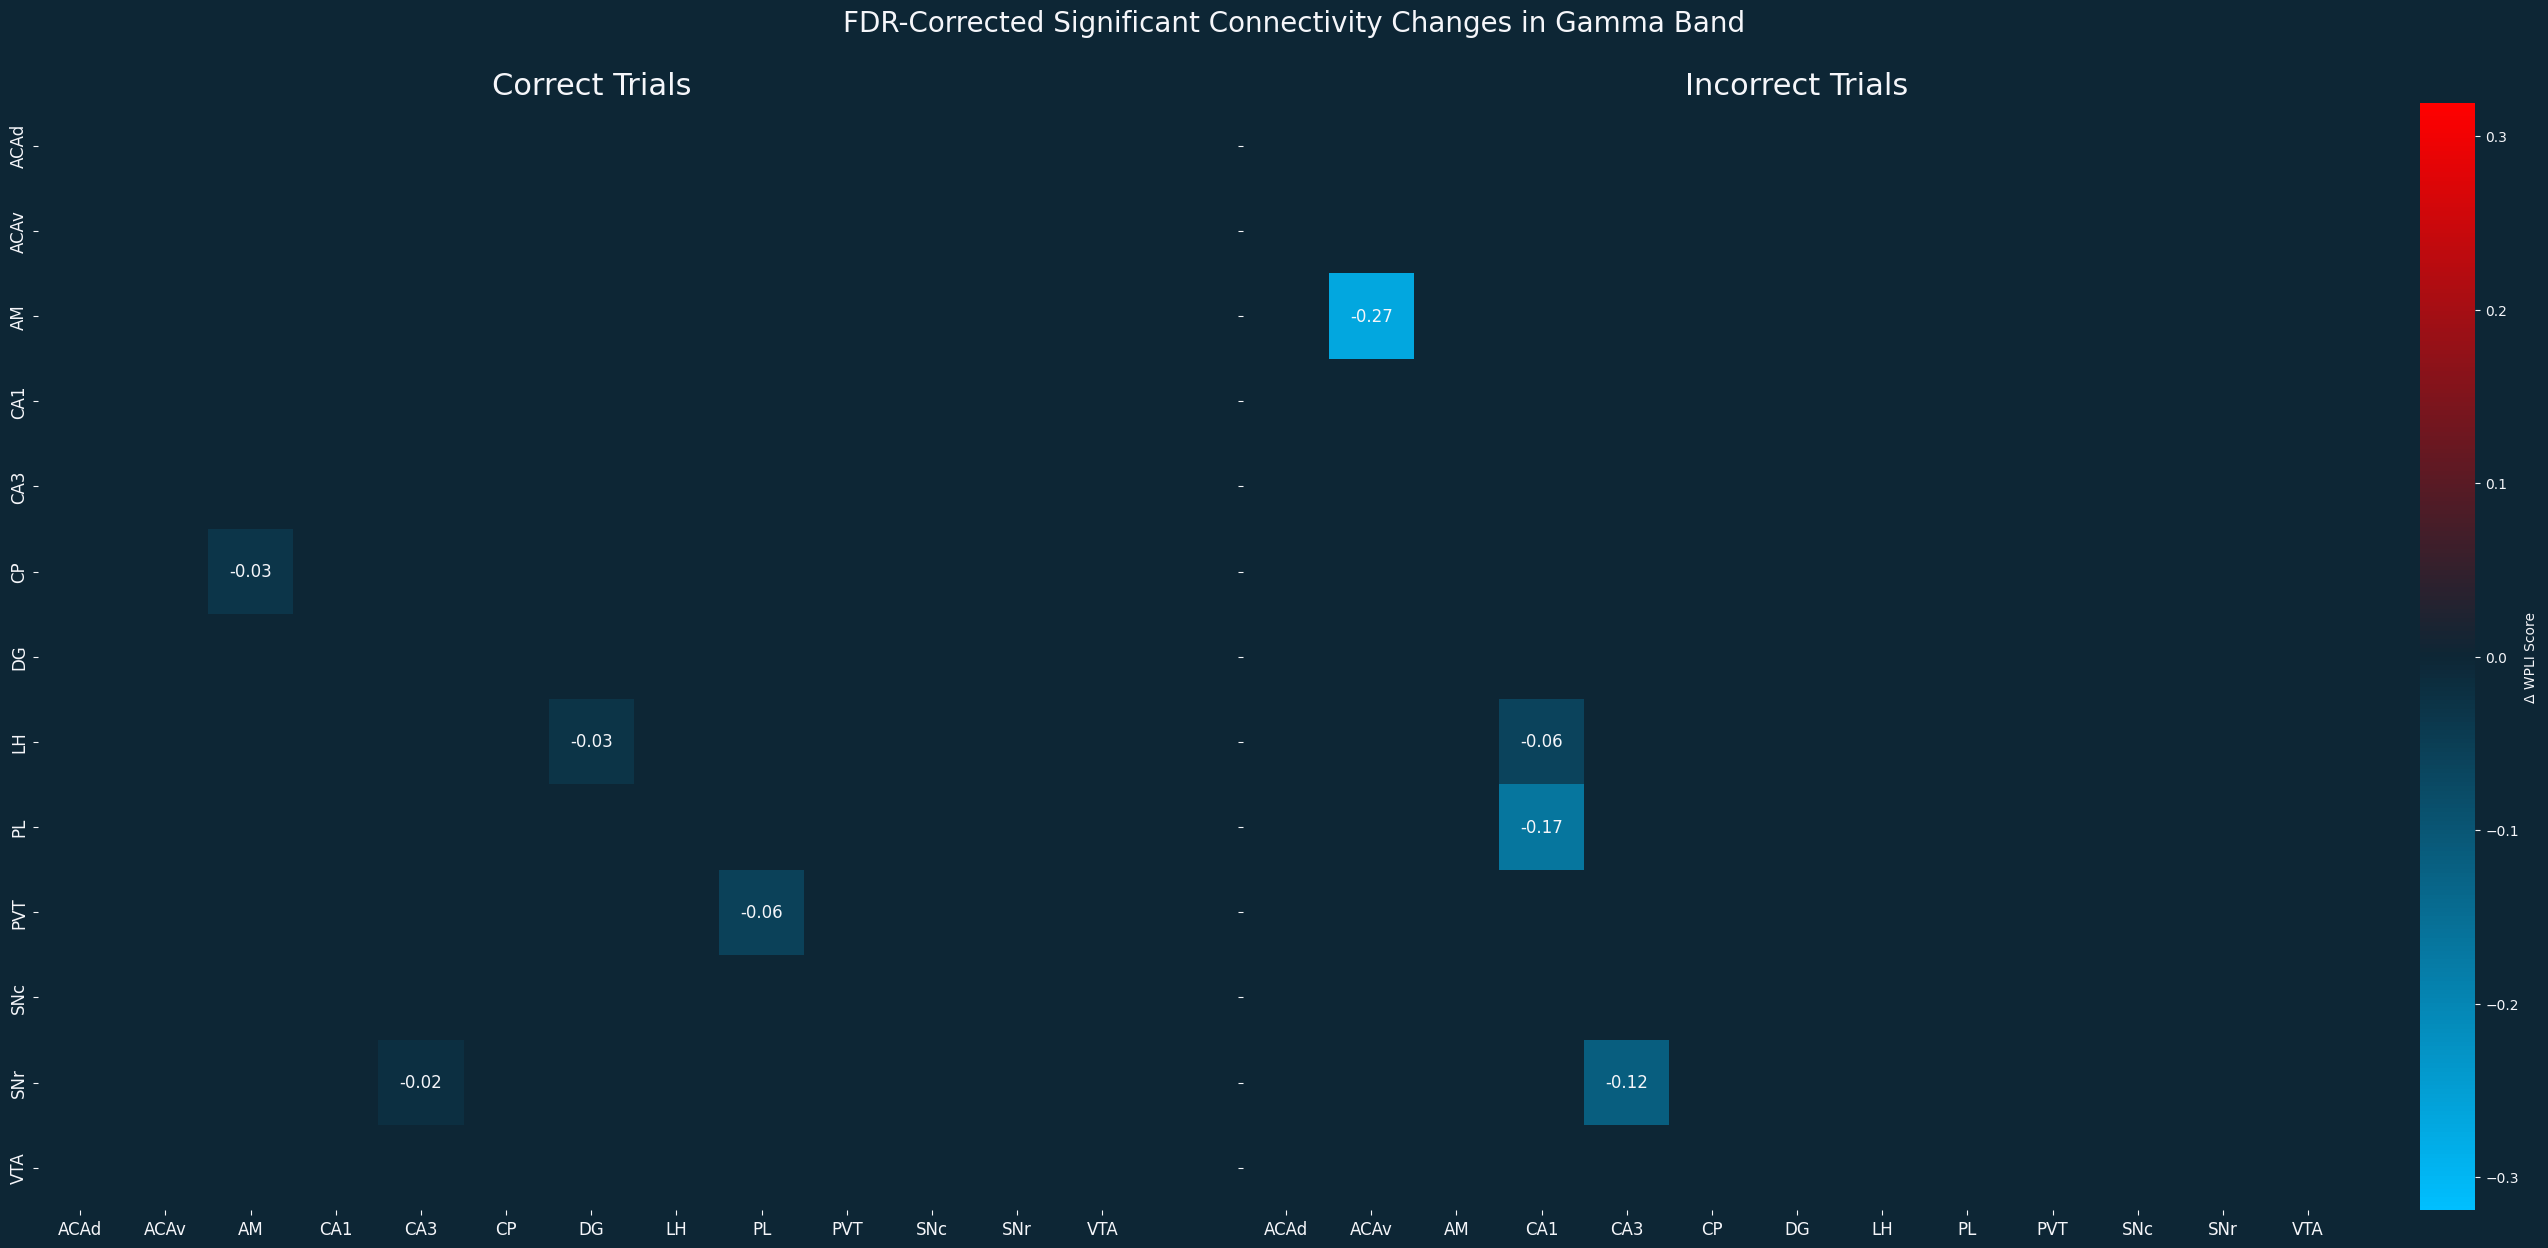

In [ ]:
SIGNIFICANCE_THRESHOLD = 0.05

is_significant_corr, q_values_corr = fdrcorrection(df_correct['p_value'], alpha=SIGNIFICANCE_THRESHOLD)
df_correct['q_value'] = q_values_corr
df_correct['Significant'] = is_significant_corr

is_significant_incorr, q_values_incorr = fdrcorrection(df_incorrect['p_value'], alpha=SIGNIFICANCE_THRESHOLD)
df_incorrect['q_value'] = q_values_incorr
df_incorrect['Significant'] = is_significant_incorr

print("--- FDR Correction Results for Correct Trials ---")
display(df_correct.sort_values(by='q_value'))

print("\n--- FDR Correction Results for Incorrect Trials ---")
display(df_incorrect.sort_values(by='q_value'))

# Plotting setup
dark_bg_color = "#0d2635"
light_text_color = "#f5f6fa"
cmap = LinearSegmentedColormap.from_list("custom_blue_crimson", ["#00bfff", dark_bg_color, "#FF0000"])
cmap.set_bad(color=dark_bg_color)

all_rois_with_data = sorted(list(set([roi for pair in connectivity_results['correct'].keys() for roi in pair])))

for band_name in freq_bands.keys():

    # Build delta connectivity matrices
    correct_delta_matrix = pd.DataFrame(np.nan, index=all_rois_with_data, columns=all_rois_with_data)
    incorrect_delta_matrix = pd.DataFrame(np.nan, index=all_rois_with_data, columns=all_rois_with_data)

    for pair, band_scores in connectivity_results['correct'].items():
        if band_name in band_scores:
            r1, r2 = pair
            delta_score = band_scores[band_name]['post_feedback'] - band_scores[band_name]['pre_feedback']
            correct_delta_matrix.loc[r1, r2] = delta_score
            correct_delta_matrix.loc[r2, r1] = delta_score

    for pair, band_scores in connectivity_results['incorrect'].items():
        if band_name in band_scores:
            r1, r2 = pair
            delta_score = band_scores[band_name]['post_feedback'] - band_scores[band_name]['pre_feedback']
            incorrect_delta_matrix.loc[r1, r2] = delta_score
            incorrect_delta_matrix.loc[r2, r1] = delta_score

    # Mask non-significant pairs
    sig_pairs_correct = df_correct[(df_correct['Band'] == band_name) & df_correct['Significant']]['Pair'].tolist()
    sig_pairs_incorrect = df_incorrect[(df_incorrect['Band'] == band_name) & df_incorrect['Significant']]['Pair'].tolist()

    stat_masked_correct = correct_delta_matrix.copy()
    for r1 in all_rois_with_data:
        for r2 in all_rois_with_data:
            if f"{r1}-{r2}" not in sig_pairs_correct and f"{r2}-{r1}" not in sig_pairs_correct:
                stat_masked_correct.loc[r1, r2] = np.nan

    stat_masked_incorrect = incorrect_delta_matrix.copy()
    for r1 in all_rois_with_data:
        for r2 in all_rois_with_data:
            if f"{r1}-{r2}" not in sig_pairs_incorrect and f"{r2}-{r1}" not in sig_pairs_incorrect:
                stat_masked_incorrect.loc[r1, r2] = np.nan

    # Mask upper triangle
    triu_mask = np.triu(np.ones_like(correct_delta_matrix, dtype=bool))

    # Plot heatmaps
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(27, 12), sharey=True, gridspec_kw={"width_ratios": [1, 1.15]})
    fig.patch.set_facecolor(dark_bg_color)
    axes[0].set_facecolor(dark_bg_color); axes[1].set_facecolor(dark_bg_color)

    fig.suptitle(f"FDR-Corrected Significant Connectivity Changes in {band_name} Band",
                 fontsize=20, y=1.02, color=light_text_color)

    max_abs_val = np.nanmax(np.abs(np.concatenate([correct_delta_matrix.values, incorrect_delta_matrix.values])))

    # Correct trials heatmap
    sns.heatmap(stat_masked_correct, ax=axes[0], mask=triu_mask, annot=True, fmt='.2f', cmap=cmap,
                vmin=-max_abs_val, vmax=max_abs_val, square=True, cbar=False,
                annot_kws={"color": light_text_color, "size": 12})
    axes[0].set_title('Correct Trials', fontsize=22, color=light_text_color)

    # Incorrect trials heatmap
    sns.heatmap(stat_masked_incorrect, ax=axes[1], mask=triu_mask, annot=True, fmt='.2f', cmap=cmap,
                vmin=-max_abs_val, vmax=max_abs_val, square=True,
                cbar_kws={'label': 'Δ WPLI Score'},
                annot_kws={"color": light_text_color, "size": 12})
    axes[1].set_title('Incorrect Trials', fontsize=22, color=light_text_color)

    # Axis and colorbar styling
    for ax in axes:
        ax.tick_params(axis='x', colors=light_text_color, labelsize=12)
        ax.tick_params(axis='y', colors=light_text_color, labelsize=12)

    cbar = axes[1].collections[0].colorbar
    cbar.ax.yaxis.label.set_color(light_text_color); cbar.ax.tick_params(colors=light_text_color)
    plt.tight_layout(w_pad=3)
    plt.show()

plt.style.use('default')
